In [322]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import PillowWriter
from matplotlib.animation import FuncAnimation, PillowWriter
import plotly.express as px
import plotly.graph_objects as go
import json
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.exceptions import SpotifyException
from tqdm import tqdm
import time
from plotly.subplots import make_subplots 


In [95]:
cli_cred_manager = SpotifyClientCredentials(client_id="3be9acd2dbcb4943b4573e5659d7f6ba",client_secret="53e274002b594989858aa743b4e81fc3")
sp = spotipy.Spotify(client_credentials_manager=cli_cred_manager)

In [116]:
world_artists = pd.read_csv("../data/top-world-artists-generalized.csv")
vn_artists = pd.read_csv("../data/top-vn-artists-generalized.csv")
train_artists = pd.read_csv("../data/train_data_artists.csv")

In [245]:
daily_world_tracks = pd.read_csv("../data/top-daily-world-final.csv")
daily_vn_tracks = pd.read_csv("../data/top-daily-vn-final.csv")

In [68]:
train_data = pd.read_csv("../data/train_data_with_genre.csv")

In [69]:
train_data.head()

track_id        track_name               artist_id   
0  2plbrEY59IikOBgBGLjaoe  Die With A Smile  1HY2Jd0NmPuamShAr6KMms  \
1  5R8dQOPq8haW94K7mgERlO        Poker Face  1HY2Jd0NmPuamShAr6KMms   
2  0SiywuOBRcynK0uKGWdCnn       Bad Romance  1HY2Jd0NmPuamShAr6KMms   
3  2x7MyWybabEz6Y6wvHuwGE        Just Dance  1HY2Jd0NmPuamShAr6KMms   
4  11BKm0j4eYoCPPpCONAVwA       Bloody Mary  1HY2Jd0NmPuamShAr6KMms   

  artist_name  popularity                         album_name genre   
0   Lady Gaga         100                   Die With A Smile   pop  \
1   Lady Gaga          76                           The Fame   pop   
2   Lady Gaga          82  The Fame Monster (Deluxe Edition)   pop   
3   Lady Gaga          74                           The Fame   pop   
4   Lady Gaga          73    Born This Way (Special Edition)   pop   

           artist_genres  duration_ms  explicit  ...  loudness  mode   
0  art pop,dance pop,pop       251667     False  ...    -7.777     0  \
1  art pop,dance pop,pop       237200     False  ...    -4.618     1   
2  art pop,dance pop,pop       294573      True  ...    -3.752     1   
3  art pop,dance pop,pop       241933     False  ...    -4.541     0   
4  art pop,dance pop,pop       244760     False  ...    -6.365     0   

   speechiness  acousticness  instrumentalness  liveness  valence    tempo   
0       0.0304       0.30800          0.000000    0.1220    0.535  157.969  \
1       0.0787       0.11900          0.000002    0.1210    0.774  119.001   
2       0.0363       0.00314          0.000053    0.0842    0.714  119.007   
3       0.0311       0.02640          0.000043    0.1810    0.745  118.990   
4       0.0291       0.01070          0.000002    0.1130    0.440   99.998   

                                        analysis_url  time_signature  
0  https://api.spotify.com/v1/audio-analysis/2plb...               3  
1  https://api.spotify.com/v1/audio-analysis/5R8d...               4  
2  https://api.spotify.com/v1/audio-analysis/0Siy...               4  
3  https://api.spotify.com/v1/audio-analysis/2x7M...               4  
4  https://api.spotify.com/v1/audio-analysis/11BK...               4  

[5 rows x 23 columns]

In [383]:
color_dict = {
    'pop': '#FF6347',        # Tomato
    'rock': '#8A2BE2',       # BlueViolet
    'hip-hop': '#FFD700',    # Gold
    'reggae': '#32CD32',     # LimeGreen
    'acoustic': '#4682B4',   # SteelBlue
    'electronic': '#00CED1', # DarkTurquoise
    'blues': '#1E90FF',      # DodgerBlue
    'jazz': '#FF69B4',       # HotPink
    'classical': '#708090' ,  # SlateGray
    "other" : "#D2691E"
}

---
# Điểm popularity của mỗi thể loại nhìn chung

In [71]:
temp = train_data.groupby("genre")["popularity"].mean().reset_index().sort_values(by="popularity", ascending=False)

fig = px.bar(
    temp,
    x="genre",  # Set x-axis to genre
    y="popularity",  # Set y-axis to popularity
    color="genre",  # Use genre column to assign colors
    color_discrete_map=color_dict  # Apply color_dict for specific genre colors
)

fig.update_layout(title="Điểm popularity nhìn chung")
fig.show()

--- 
# Các thể loại chứa từ ngữ nhạy cảm

In [72]:
explicit_by_genre = train_data[train_data['explicit'] == 1].groupby('genre')["explicit"].count().reset_index().sort_values(by="explicit", ascending=False)
px.bar(data_frame=explicit_by_genre, x="genre", y="explicit", color="genre", color_discrete_map=color_dict)


---
# Phân bố các trường audio features

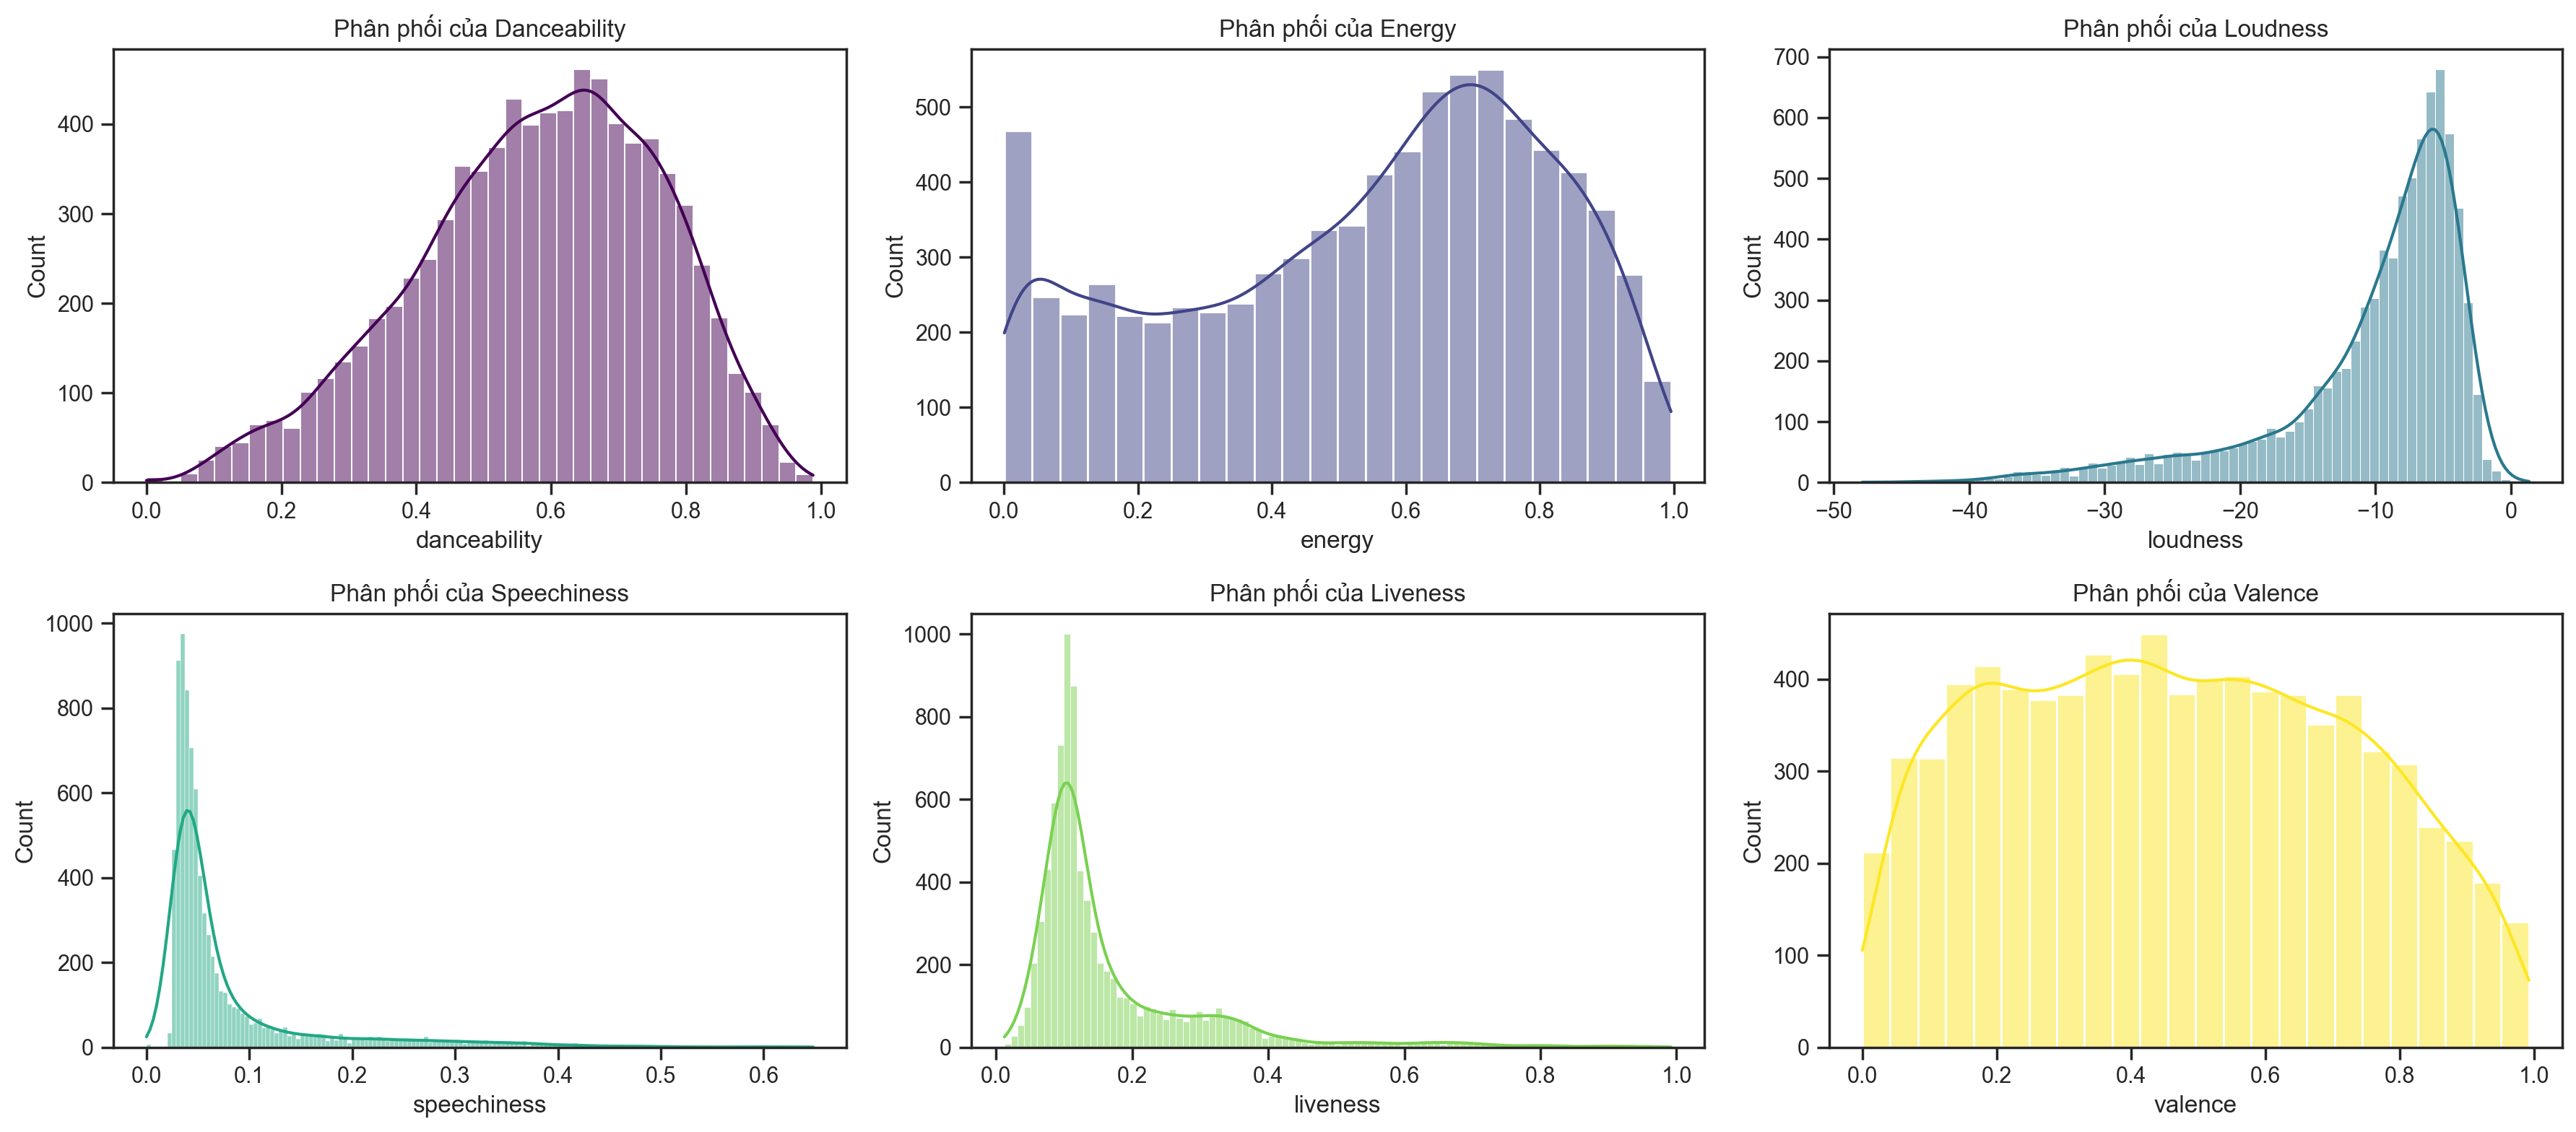

In [73]:
features = ['danceability', 'energy', 'loudness', 
            'speechiness', 'liveness', 'valence']

n_cols = 3
n_rows = (len(features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(data=train_data, x=feature, kde=True, ax=axes[i], color=plt.cm.viridis(np.linspace(0, 1, len(features)))[i])
    axes[i].set_title(f'Phân phối của {feature.capitalize()}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


---
# Ma trận tương quan của các thuộc tính audio features

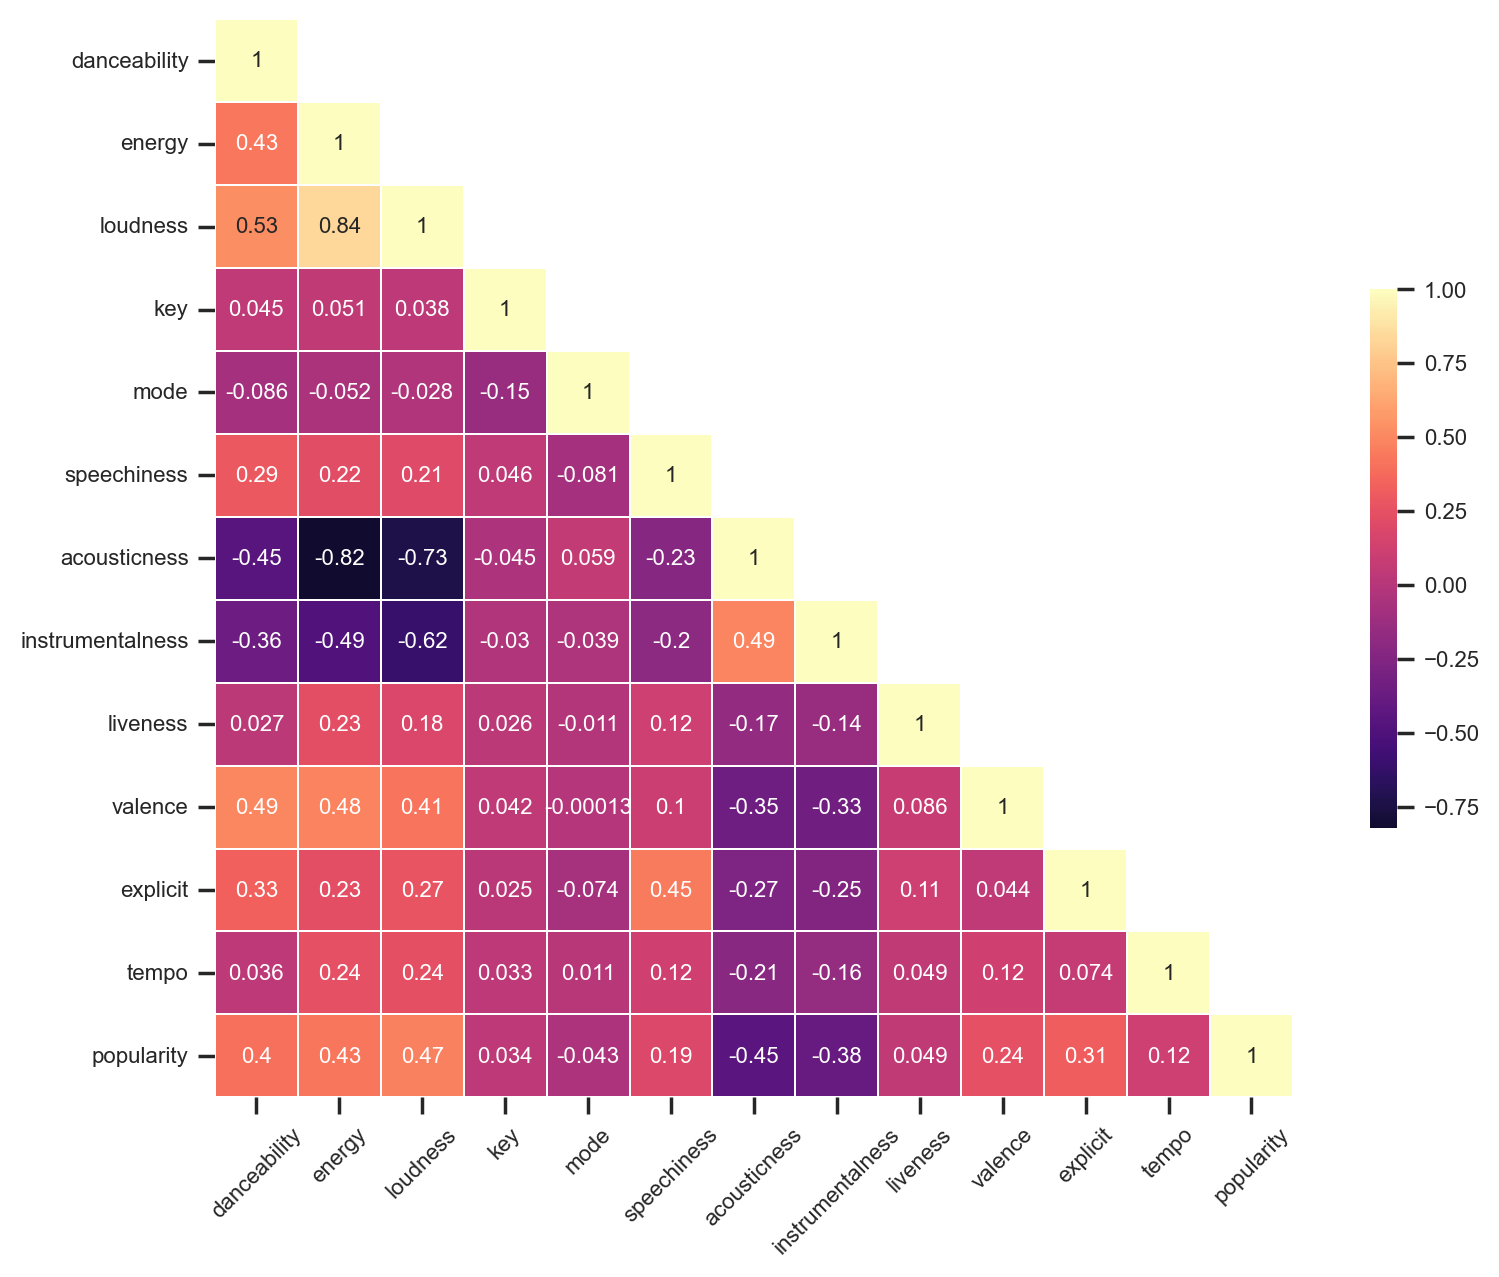

In [74]:
audio_features = ['danceability','energy', 'loudness','key',
                  'mode','speechiness','acousticness',
                  'instrumentalness','liveness','valence','explicit',
                  'tempo', 'popularity']
sns.set_theme(style="ticks")

corr = train_data[audio_features].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
for i in range(len(mask)):
    mask[i, i] = False

f, ax = plt.subplots(figsize=(10, 7), dpi=200)

heatmap = sns.heatmap(corr, mask=mask, cmap=plt.cm.magma, vmax=1, center=0,
            square=True, linewidths=0.1, annot=True, annot_kws={"size":8},cbar_kws={"shrink": .5})

ax.tick_params(axis='x', labelsize=8, rotation=45)
ax.tick_params(axis='y', labelsize=8)

heatmap.figure.axes[-1].yaxis.label.set_size(10)
heatmap.figure.axes[-1].tick_params(labelsize=8)

---
# Energy And Danceability

In [75]:
px.scatter(data_frame=train_data, x="energy", y="danceability", color="genre", color_discrete_map=color_dict, title="Energy and Danceability")


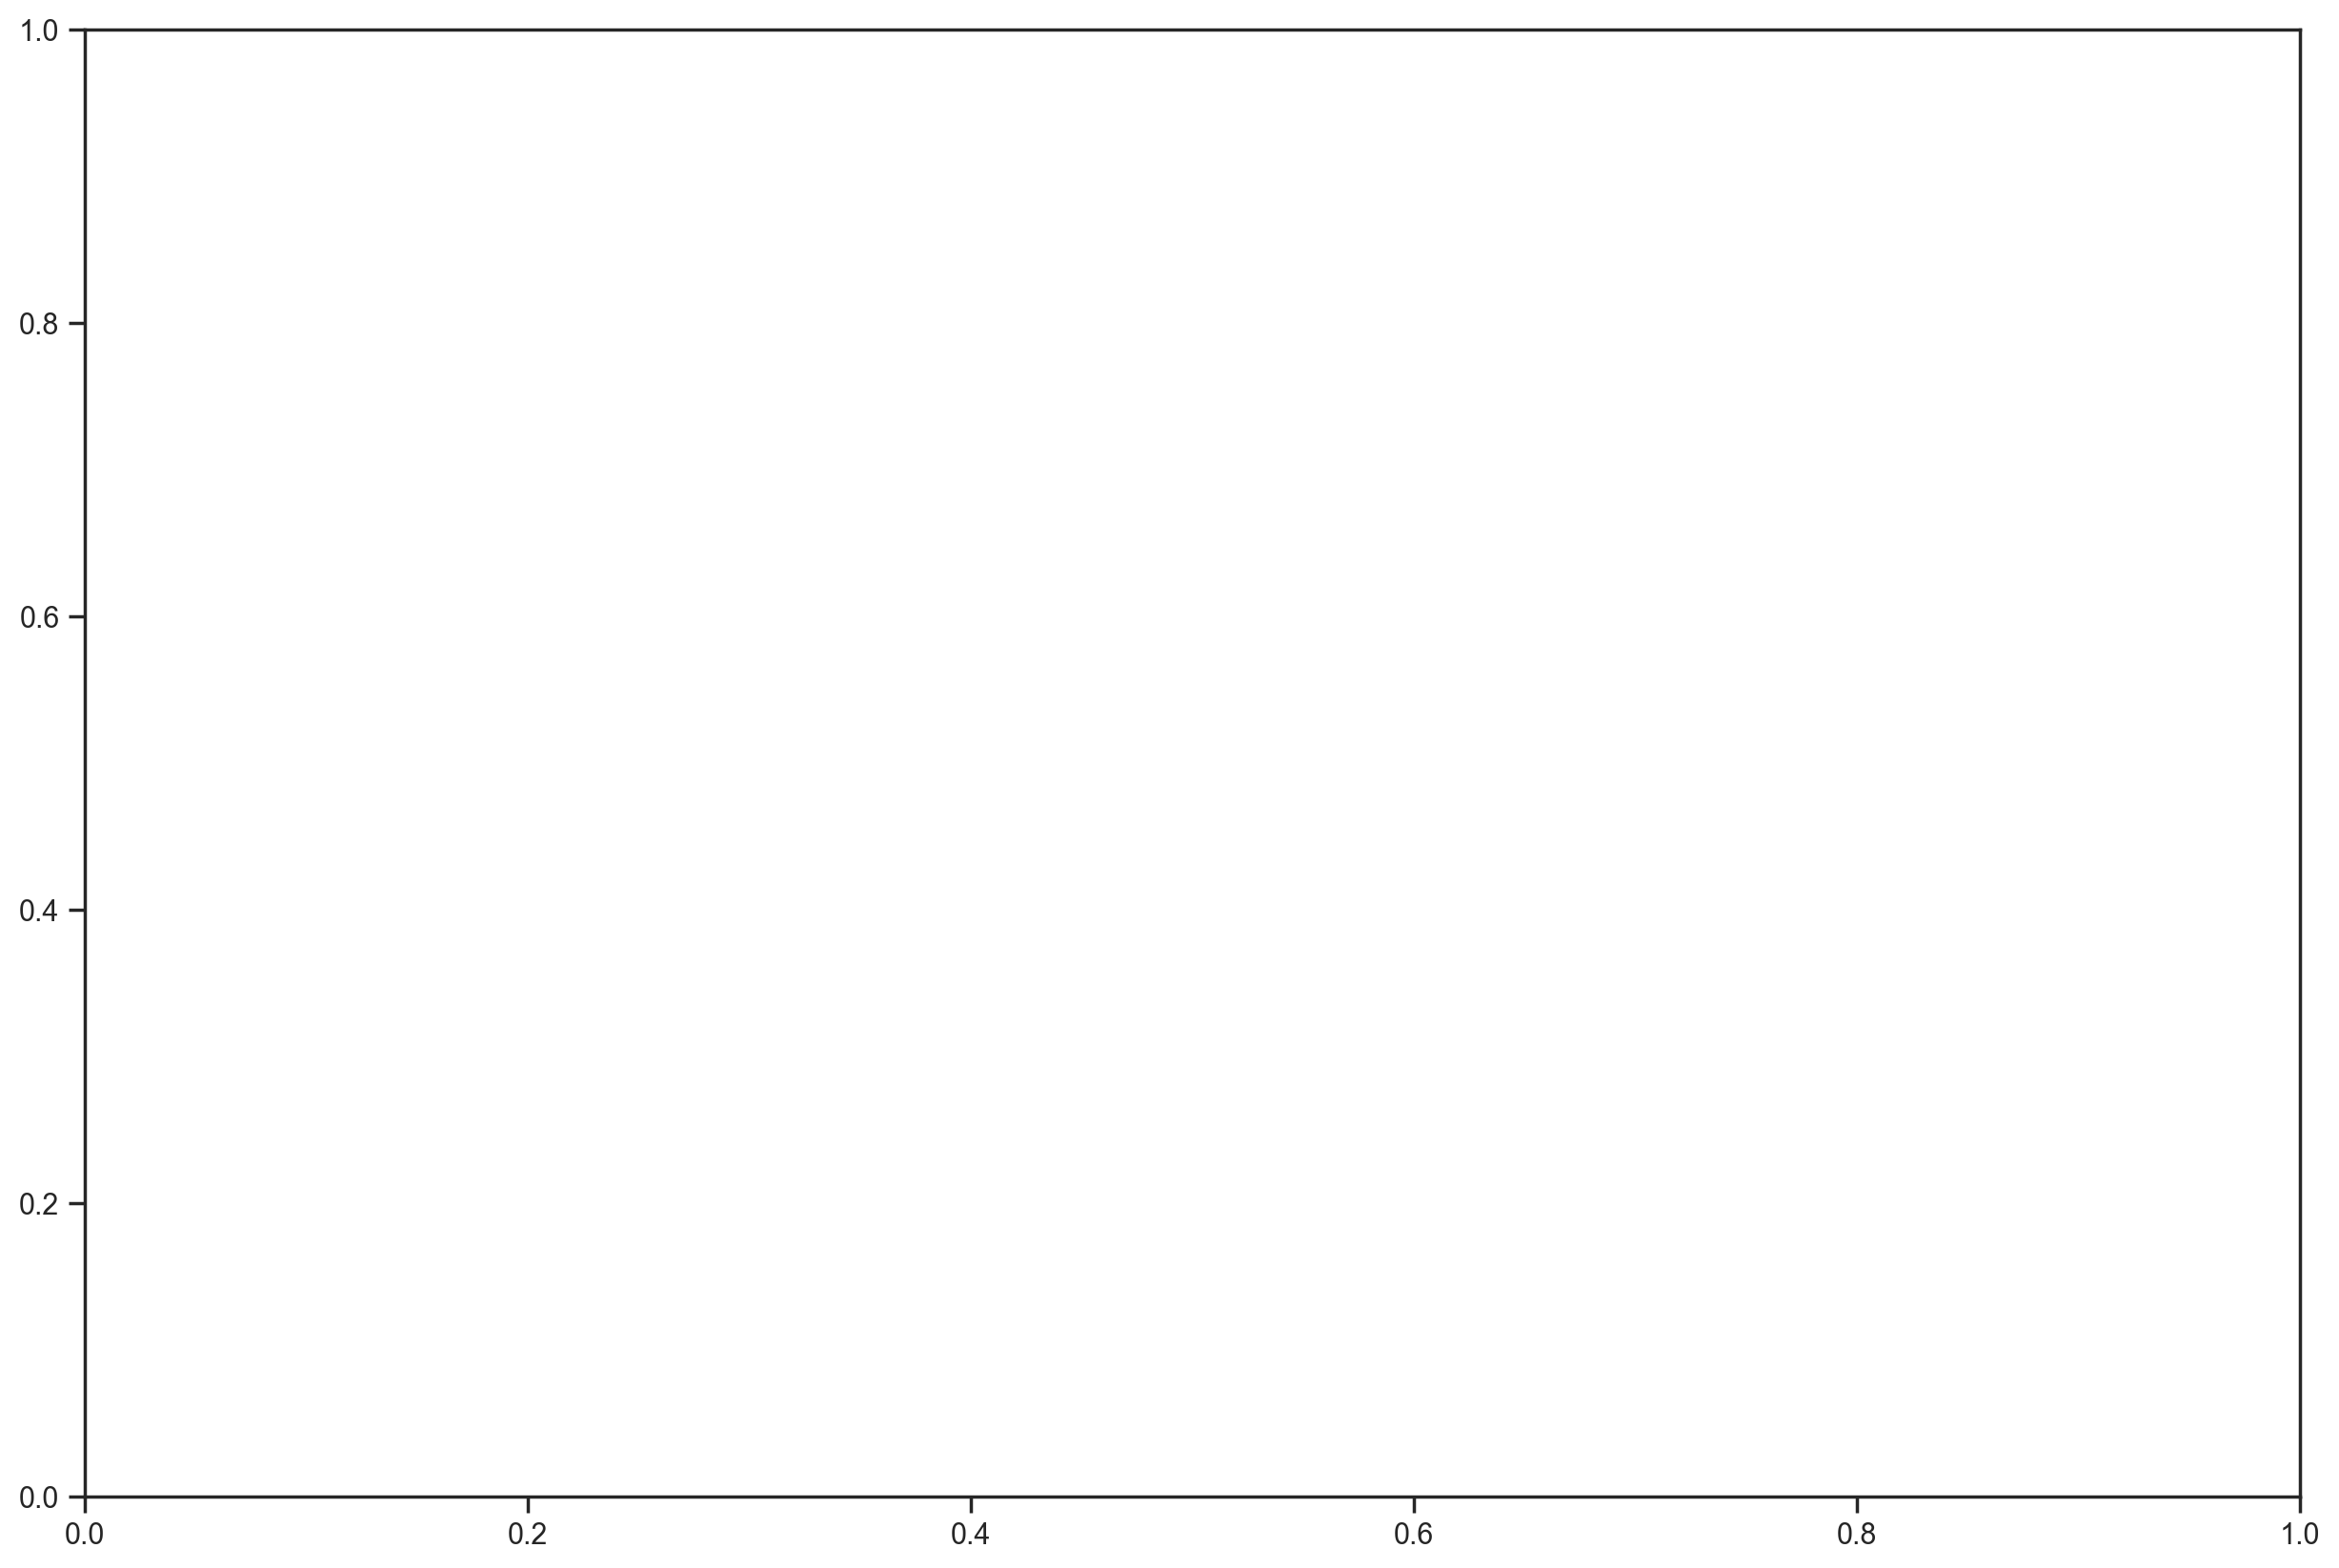

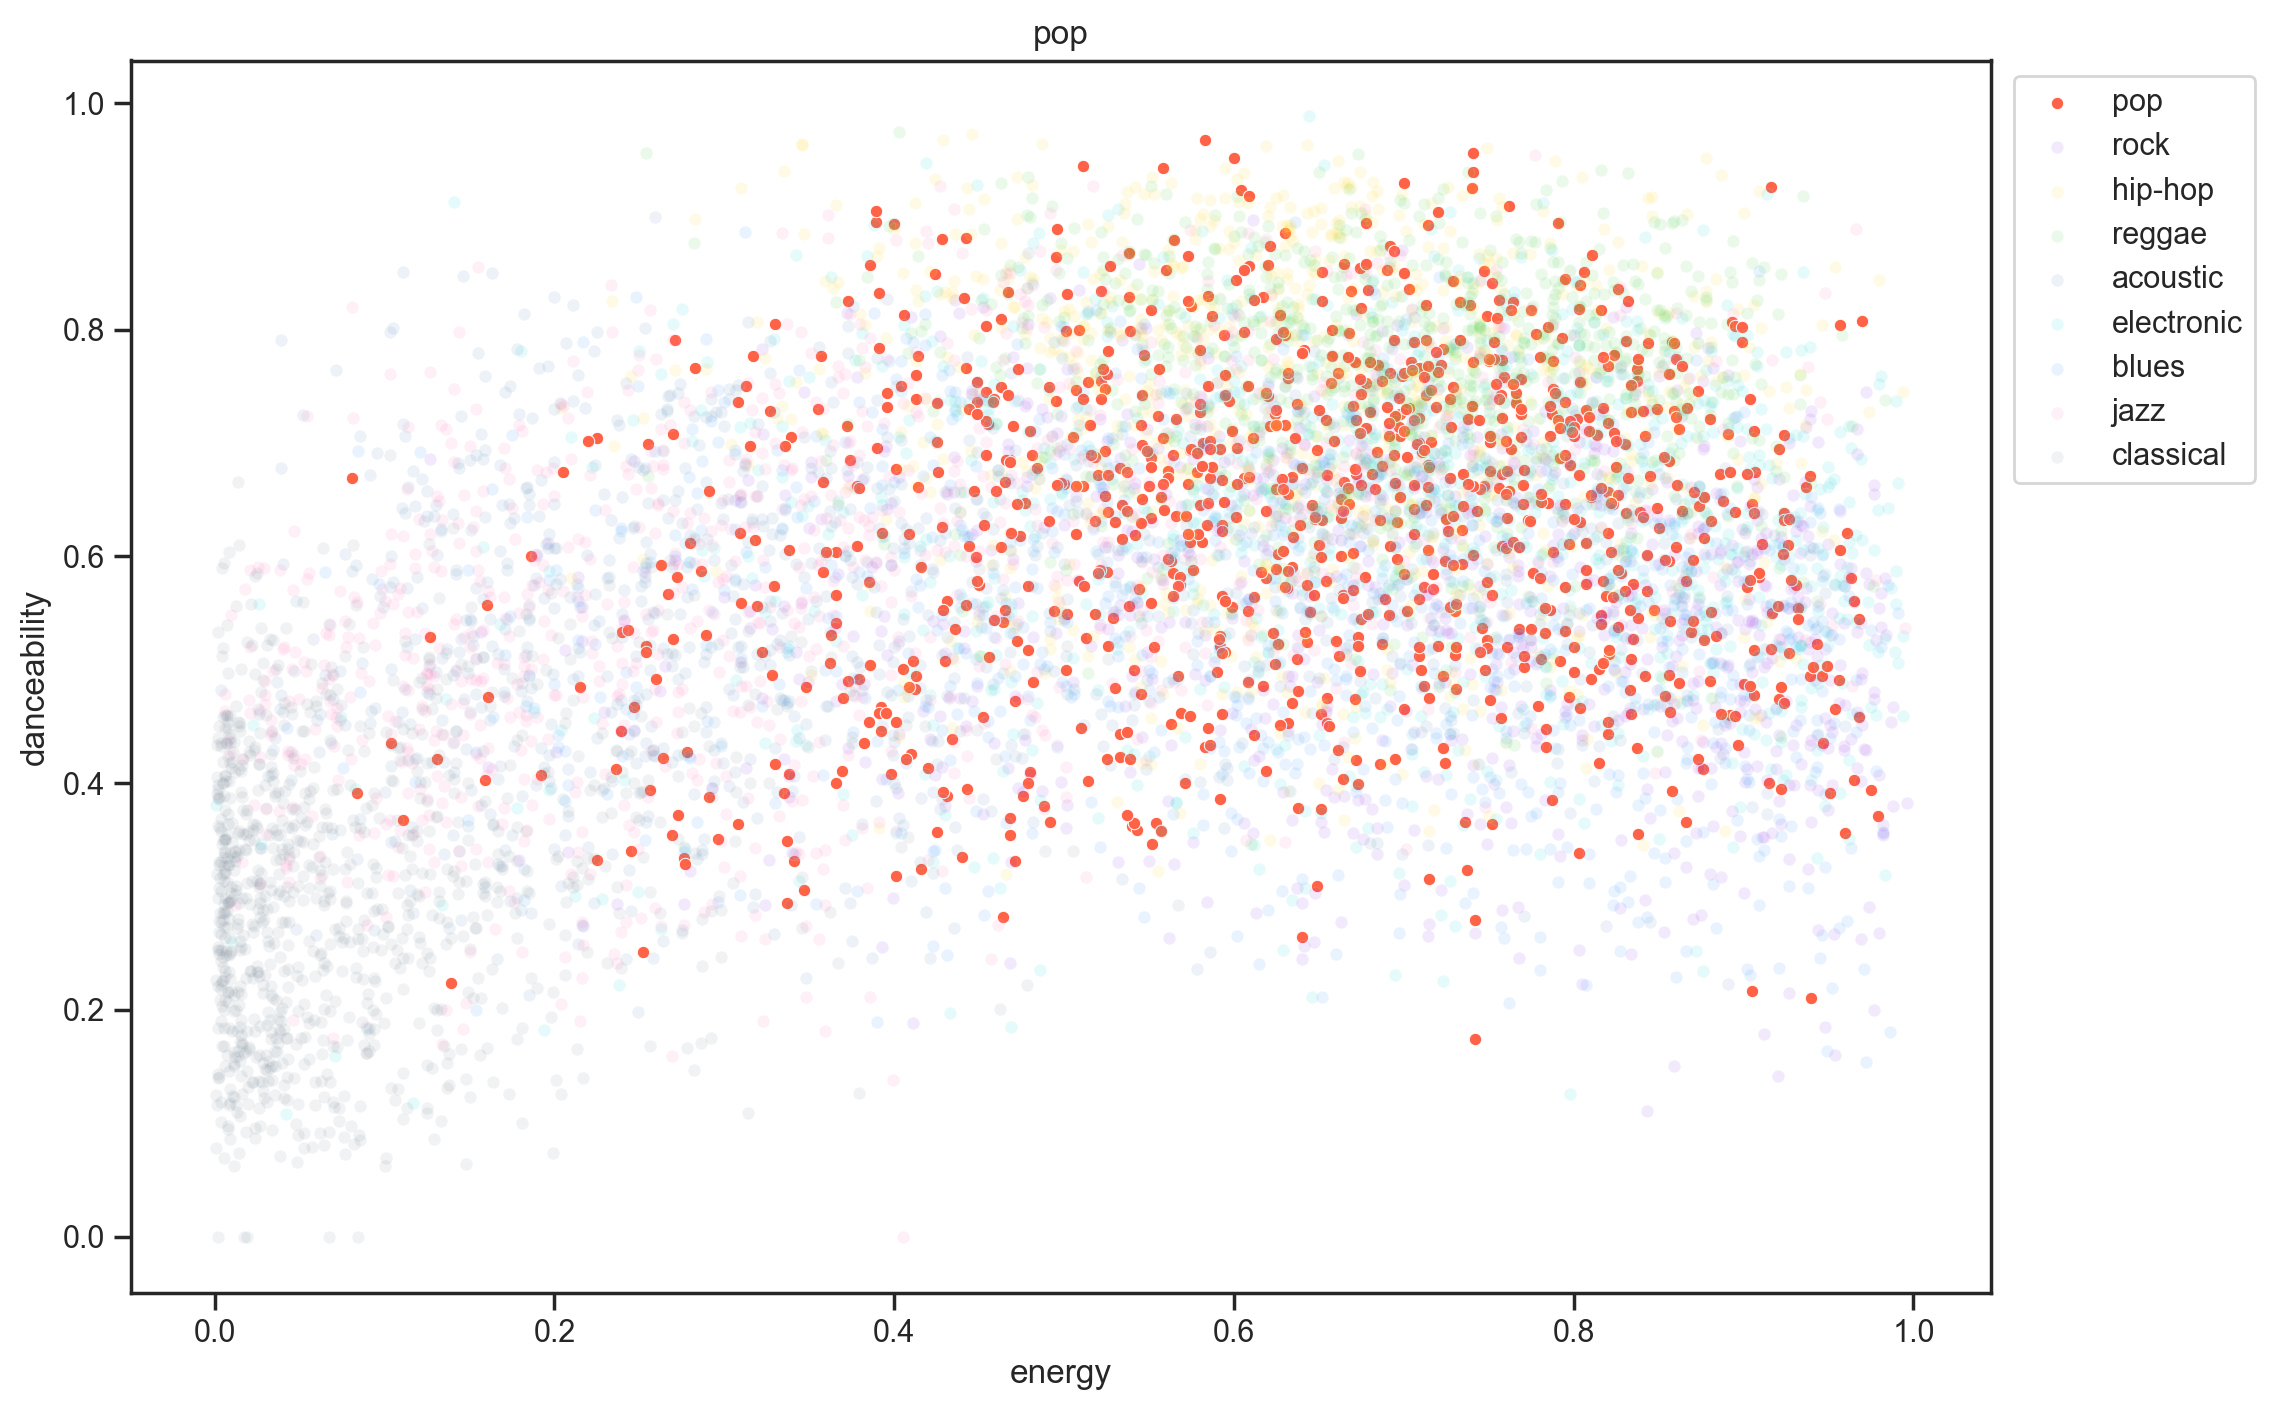

In [76]:
# Prepare plot settings
# Prepare the figure
fig, ax = plt.subplots(figsize=(15, 10))
plt.rcParams['figure.dpi'] = 200

# Function to update plot for each frame in the animation
fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['figure.dpi'] = 200

# Function to update plot for each frame in the animation
def update(selected_genre):
    ax.clear()

    # Plot all genres with reduced alpha
    for genre in train_data["genre"].unique():
        genre_data = train_data[train_data['genre'] == genre]
        sns.scatterplot(
            x='energy', y='danceability', data=genre_data, color=color_dict[genre], 
            s=20, alpha=0.1 if genre != selected_genre else 1, ax=ax, label=genre
        )
    
    # Title update for each frame
    ax.set_title(f"{selected_genre}")
    ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

# Get unique genres to loop through
unique_genres = train_data['genre'].unique()

# Create the animation
anim = FuncAnimation(fig, update, frames=unique_genres, repeat=True)

# Save the animation as a GIF without using `with` context
gif_path = "../result/energy-vs-danceability.gif"
writer = PillowWriter(fps=1)
anim.save(gif_path, writer=writer, dpi=200)

---
# Energy and Loudness

In [77]:
px.scatter(data_frame=train_data, x="energy", y="loudness", color="genre", color_discrete_map=color_dict, title="Energy and Loudness")


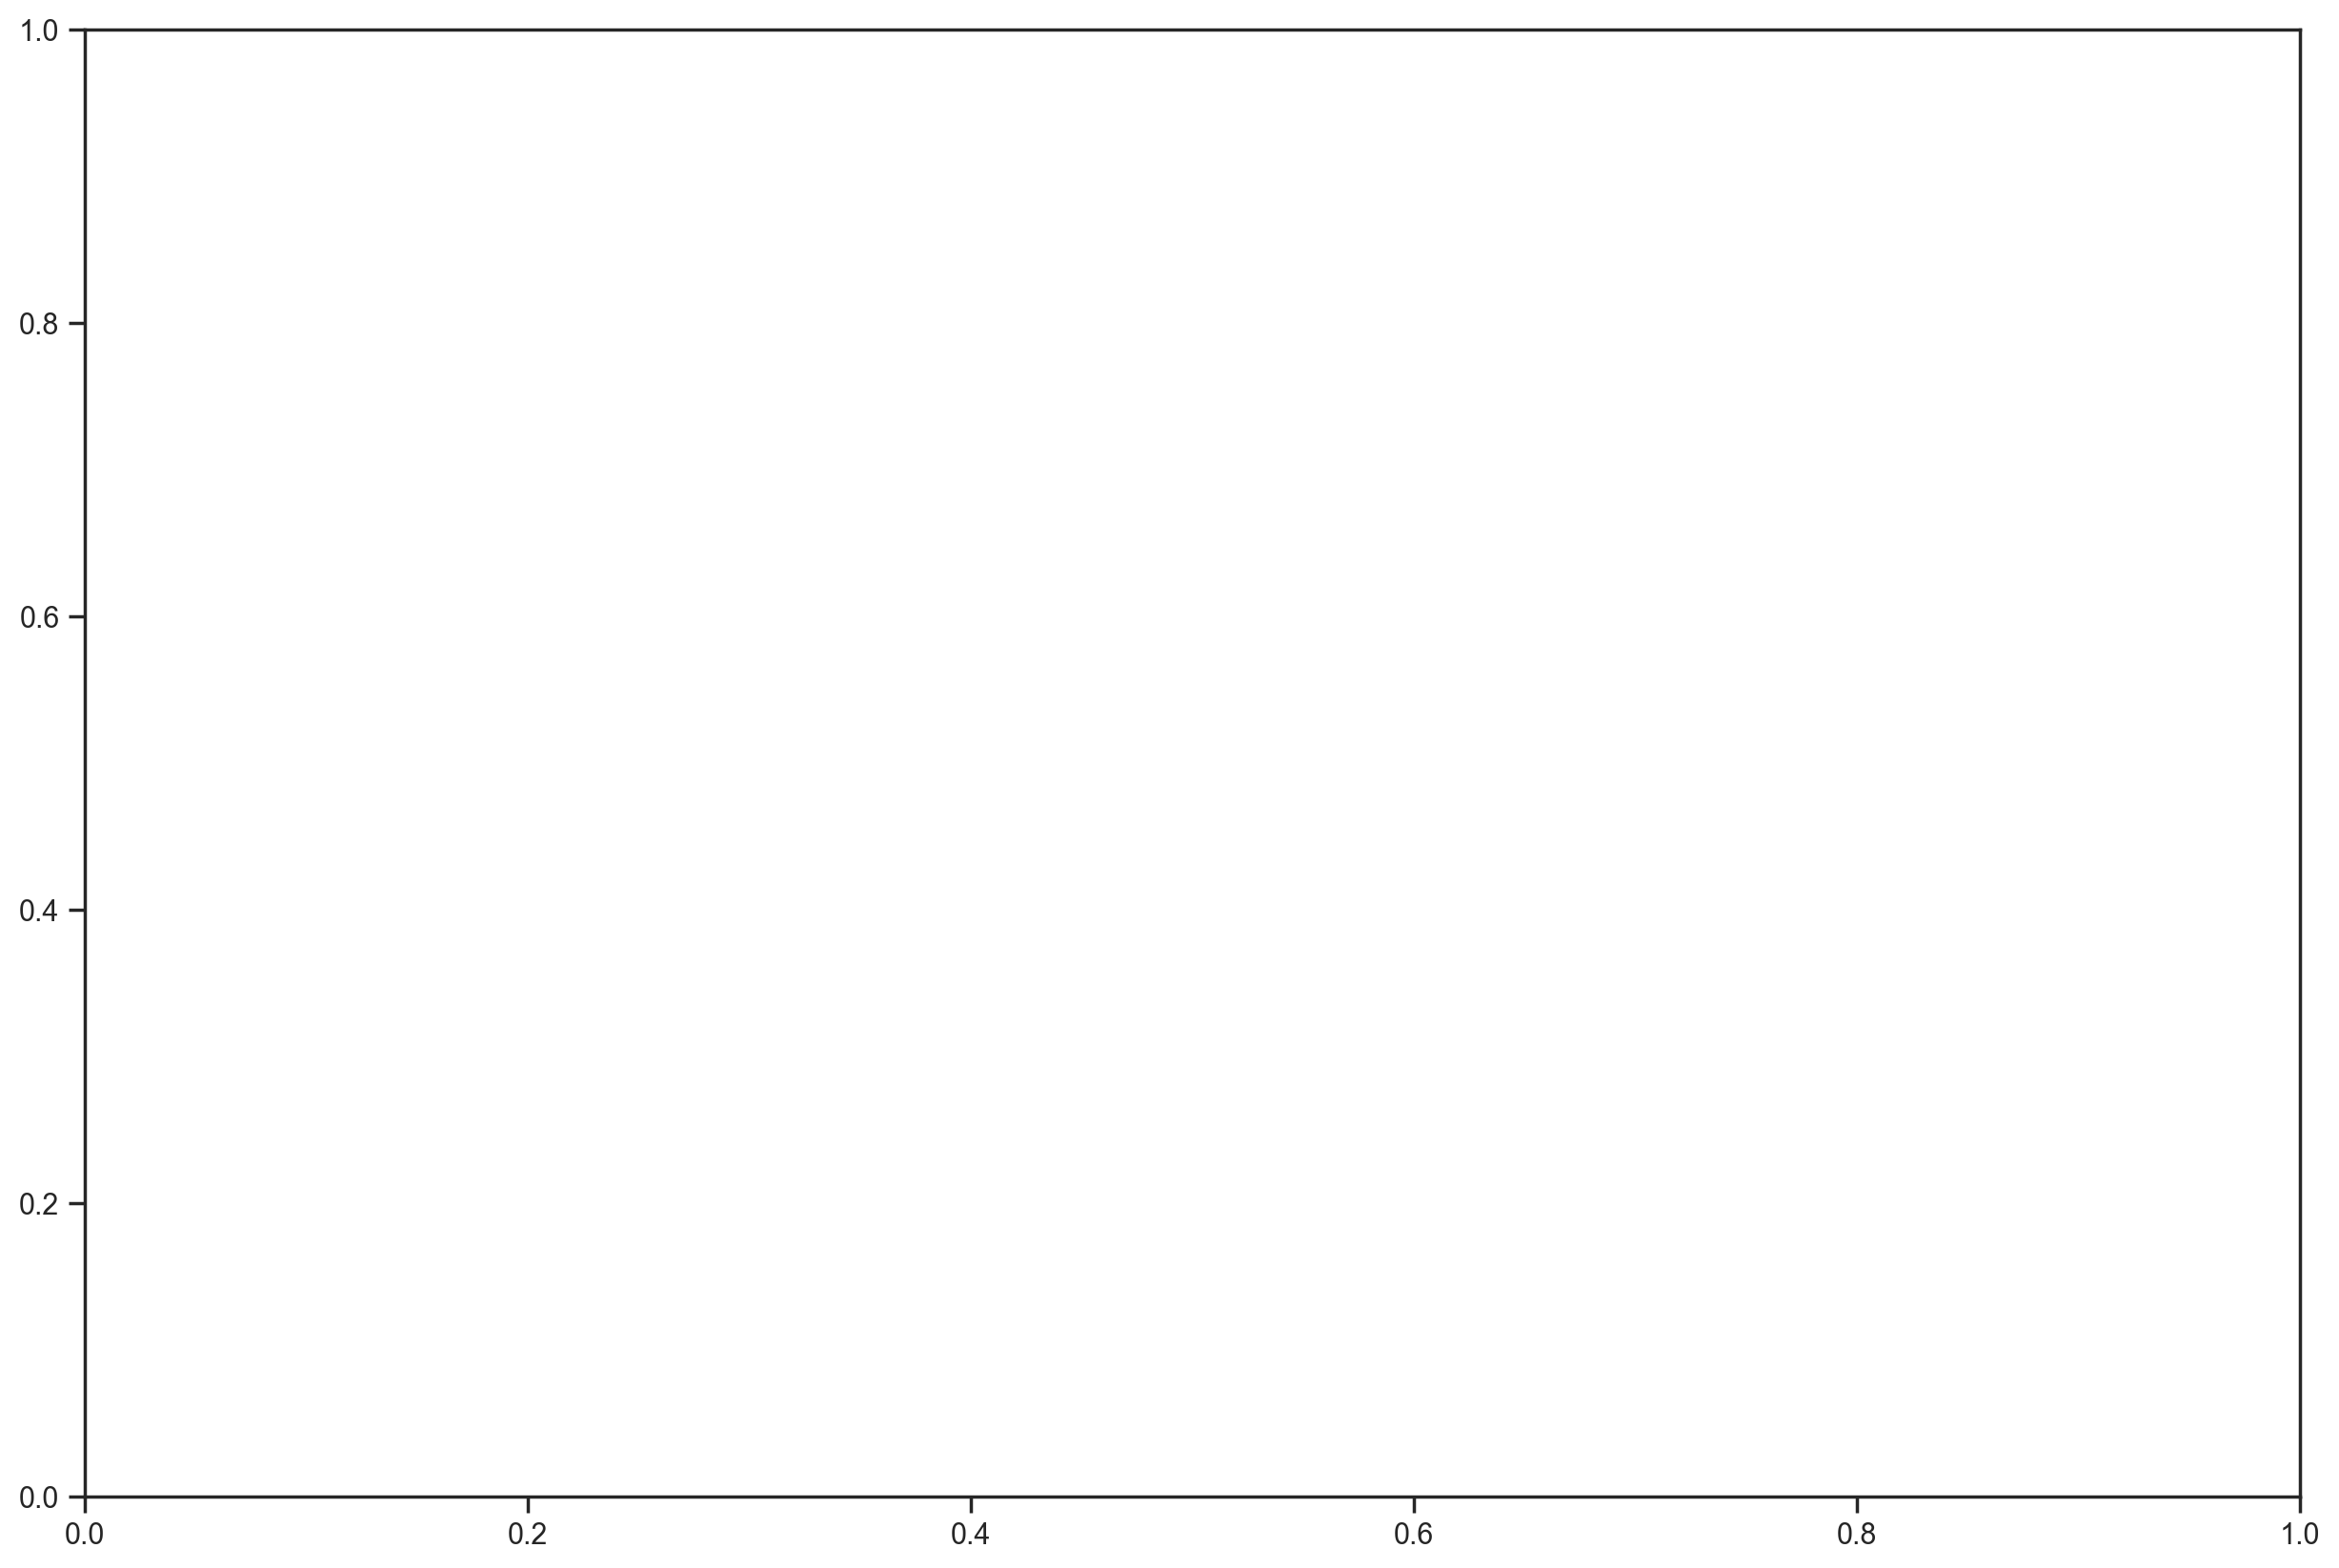

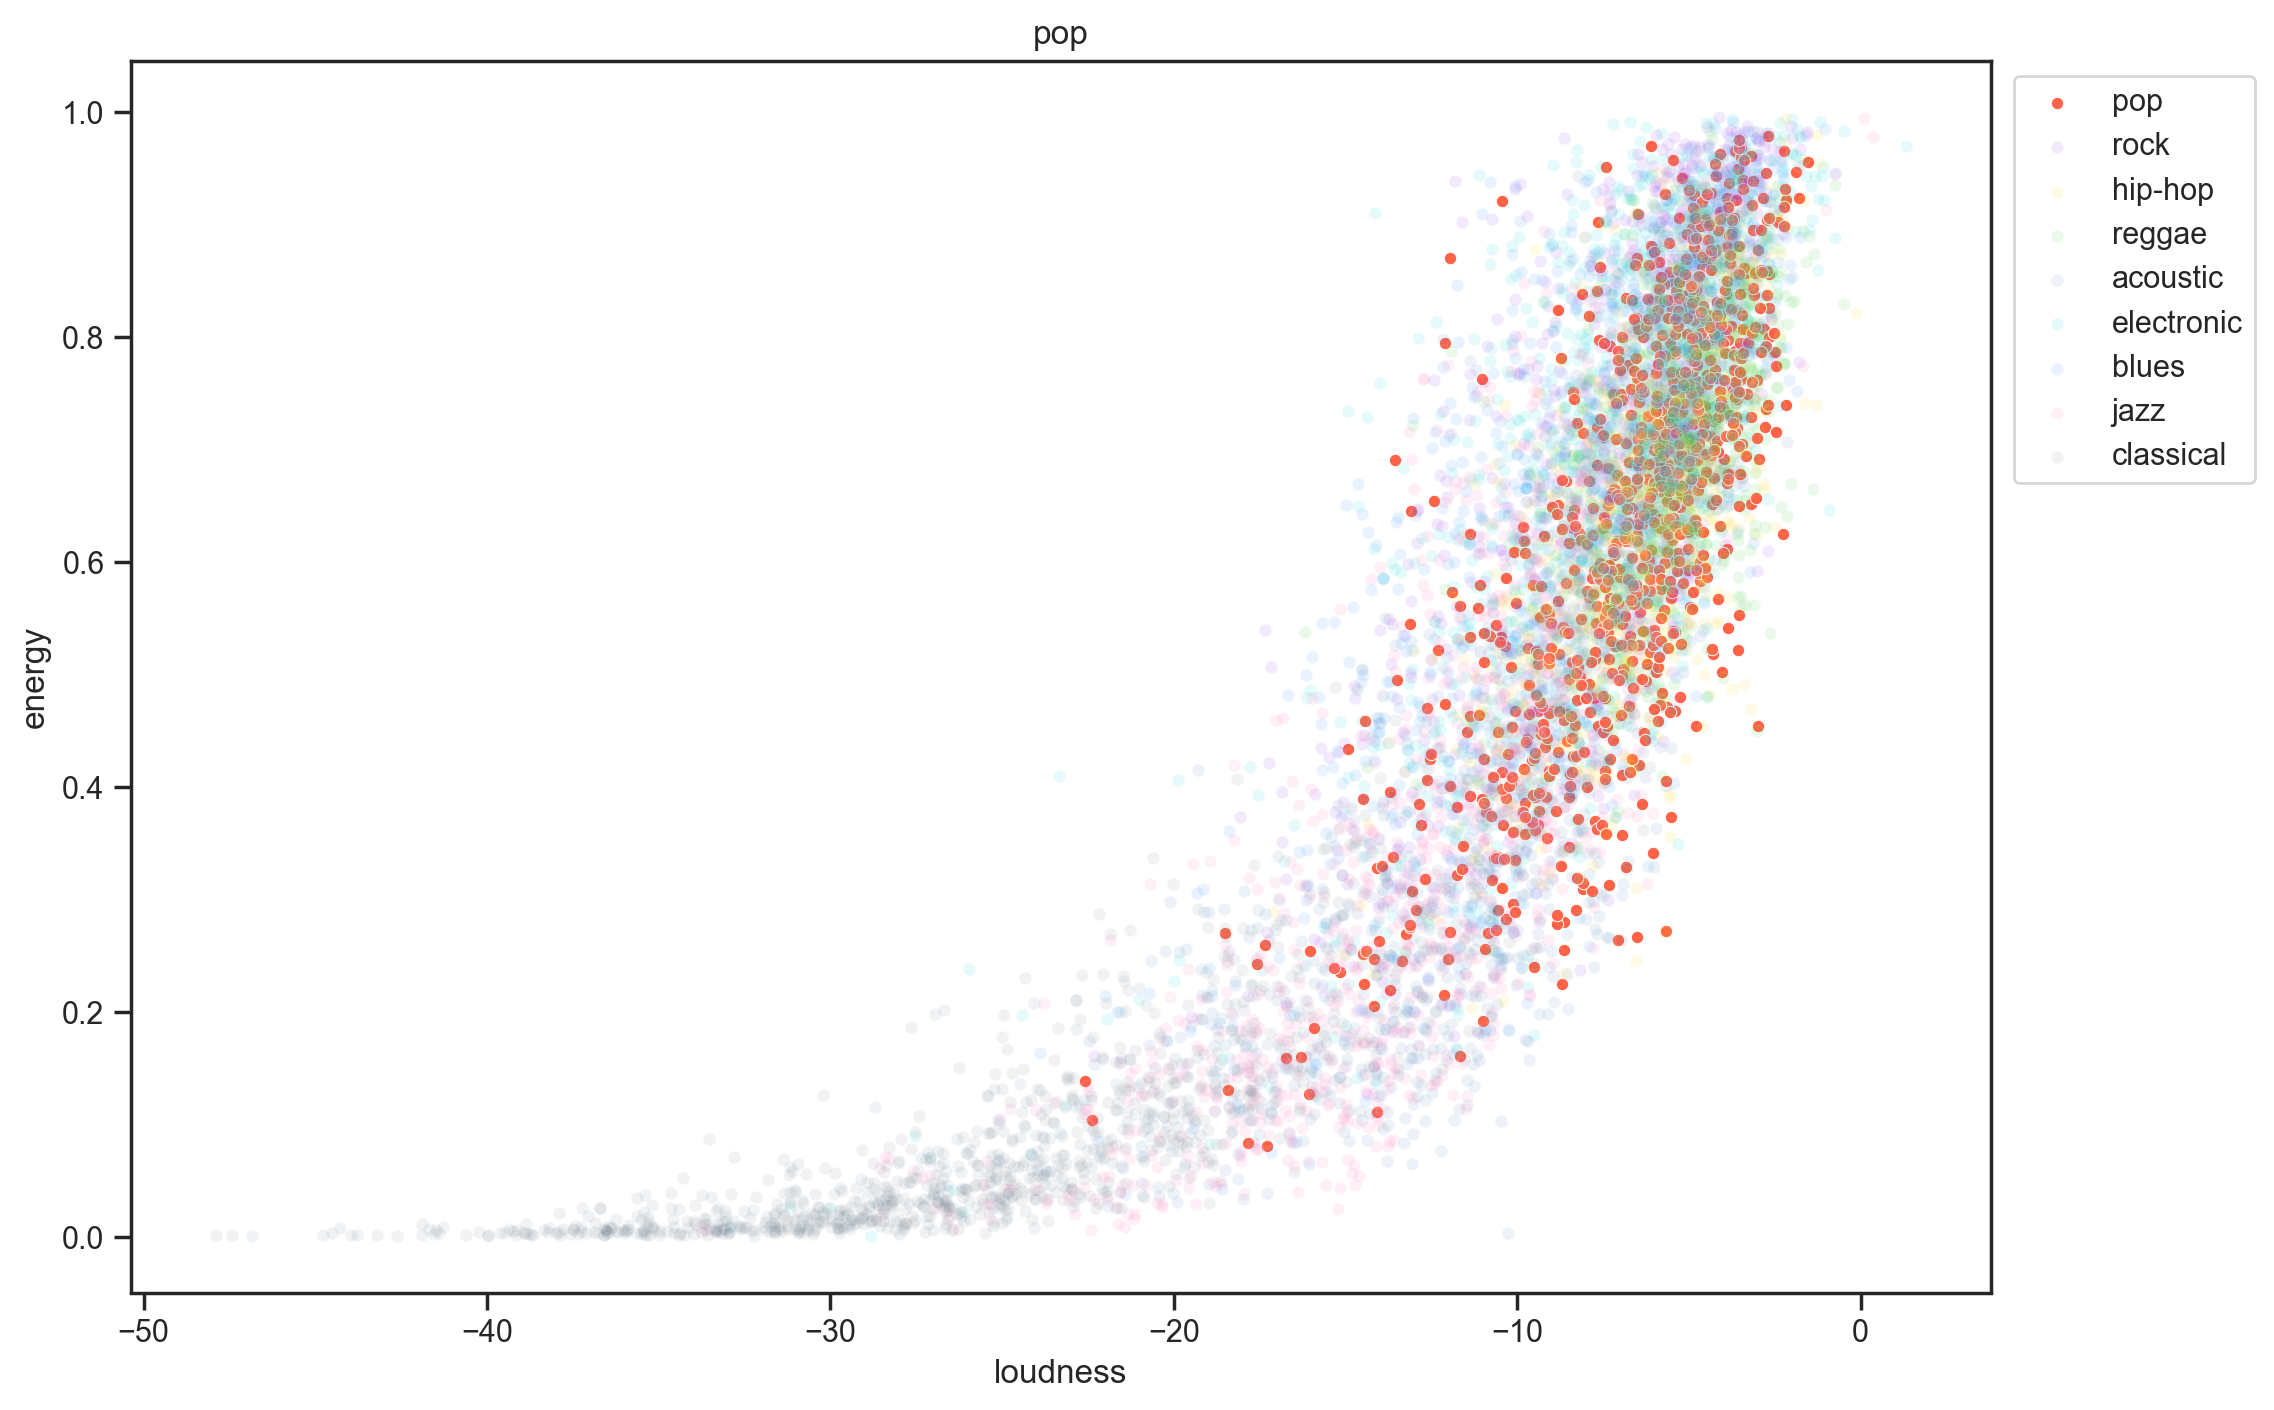

In [78]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.rcParams['figure.dpi'] = 200

color_dict = {
    'pop': '#FF6347',        # Tomato
    'rock': '#8A2BE2',       # BlueViolet
    'hip-hop': '#FFD700',    # Gold
    'reggae': '#32CD32',     # LimeGreen
    'acoustic': '#4682B4',   # SteelBlue
    'electronic': '#00CED1', # DarkTurquoise
    'blues': '#1E90FF',      # DodgerBlue
    'jazz': '#FF69B4',       # HotPink
    'classical': '#708090'   # SlateGray
}


# Function to update plot for each frame in the animation
fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['figure.dpi'] = 200

# Function to update plot for each frame in the animation
def update(selected_genre):
    ax.clear()

    # Plot all genres with reduced alpha
    for genre in train_data["genre"].unique():
        genre_data = train_data[train_data['genre'] == genre]
        sns.scatterplot(
            x='loudness', y='energy', data=genre_data, color=color_dict[genre], 
            s=20, alpha=0.1 if genre != selected_genre else 1, ax=ax, label=genre
        )
    
    # Title update for each frame
    ax.set_title(f"{selected_genre}")
    ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

# Get unique genres to loop through
unique_genres = train_data['genre'].unique()

# Create the animation
anim = FuncAnimation(fig, update, frames=unique_genres, repeat=True)

# Save the animation as a GIF without using `with` context
gif_path = "../result/loudness-vs-energy.gif"
writer = PillowWriter(fps=1)
anim.save(gif_path, writer=writer, dpi=200)

---
# Acousticness and Instrumentalness

In [79]:
px.scatter(data_frame=train_data, x="acousticness", y="instrumentalness", color="genre", color_discrete_map=color_dict, title="Acousticness and Instrumentalness")


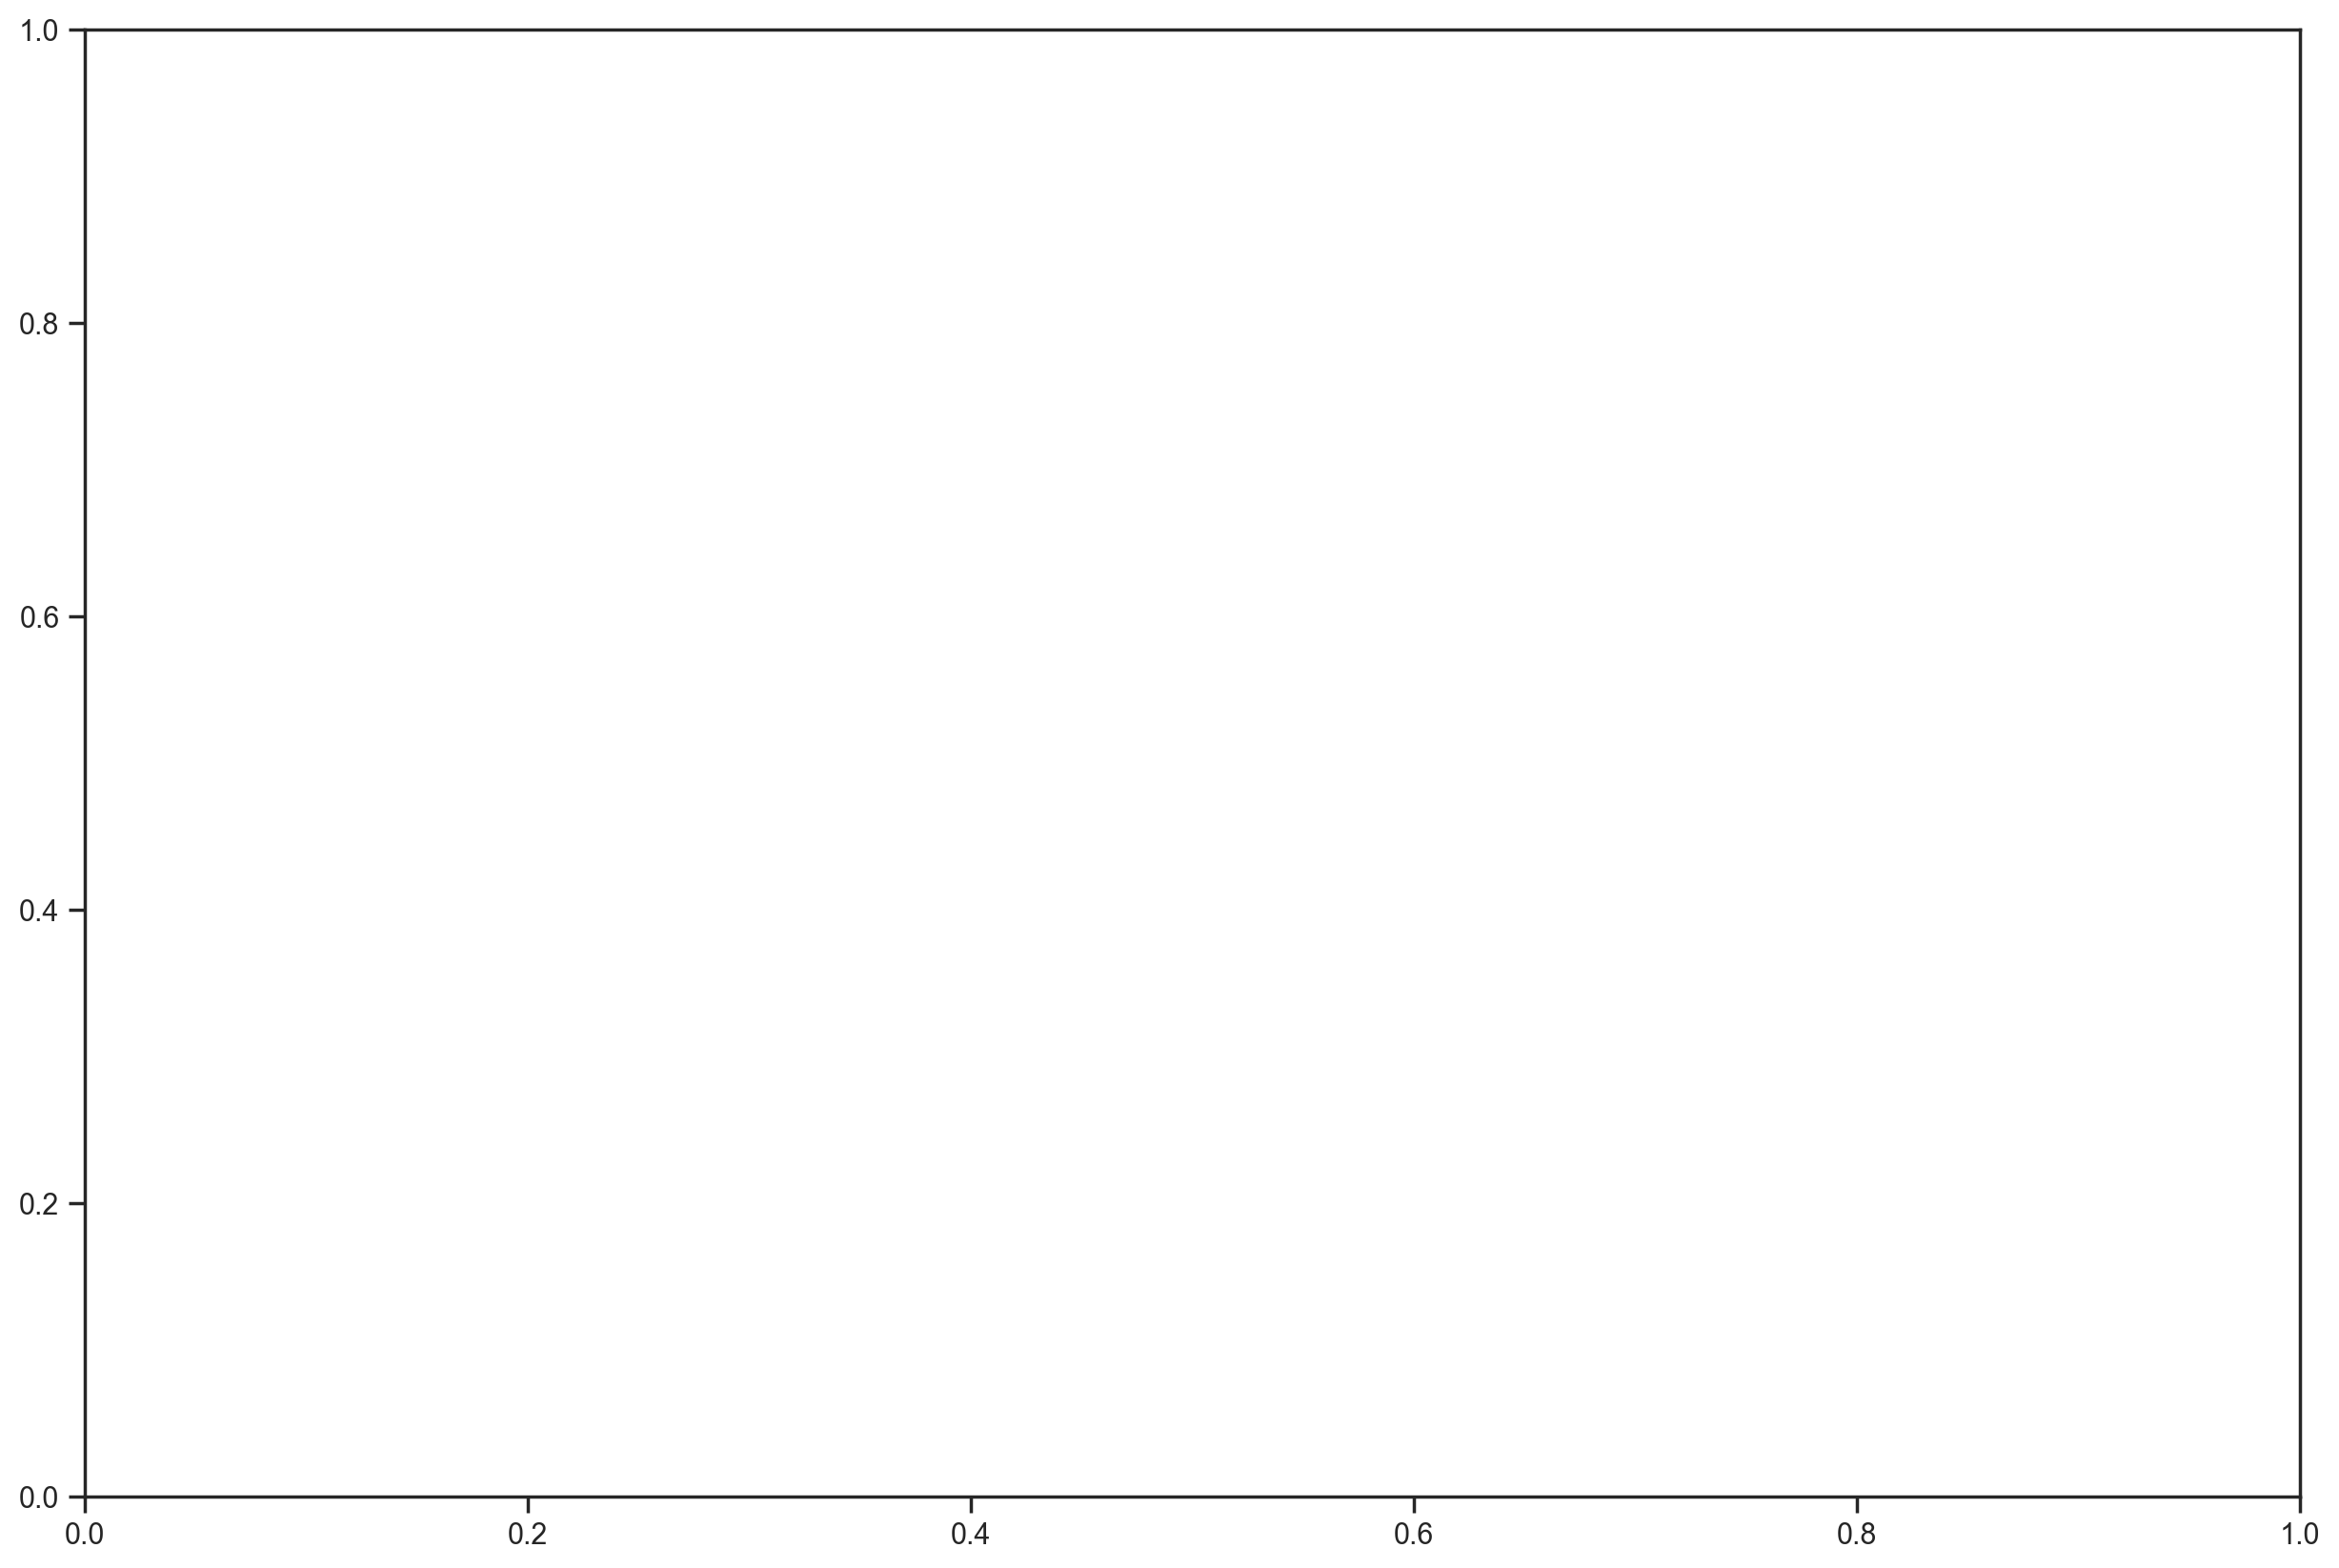

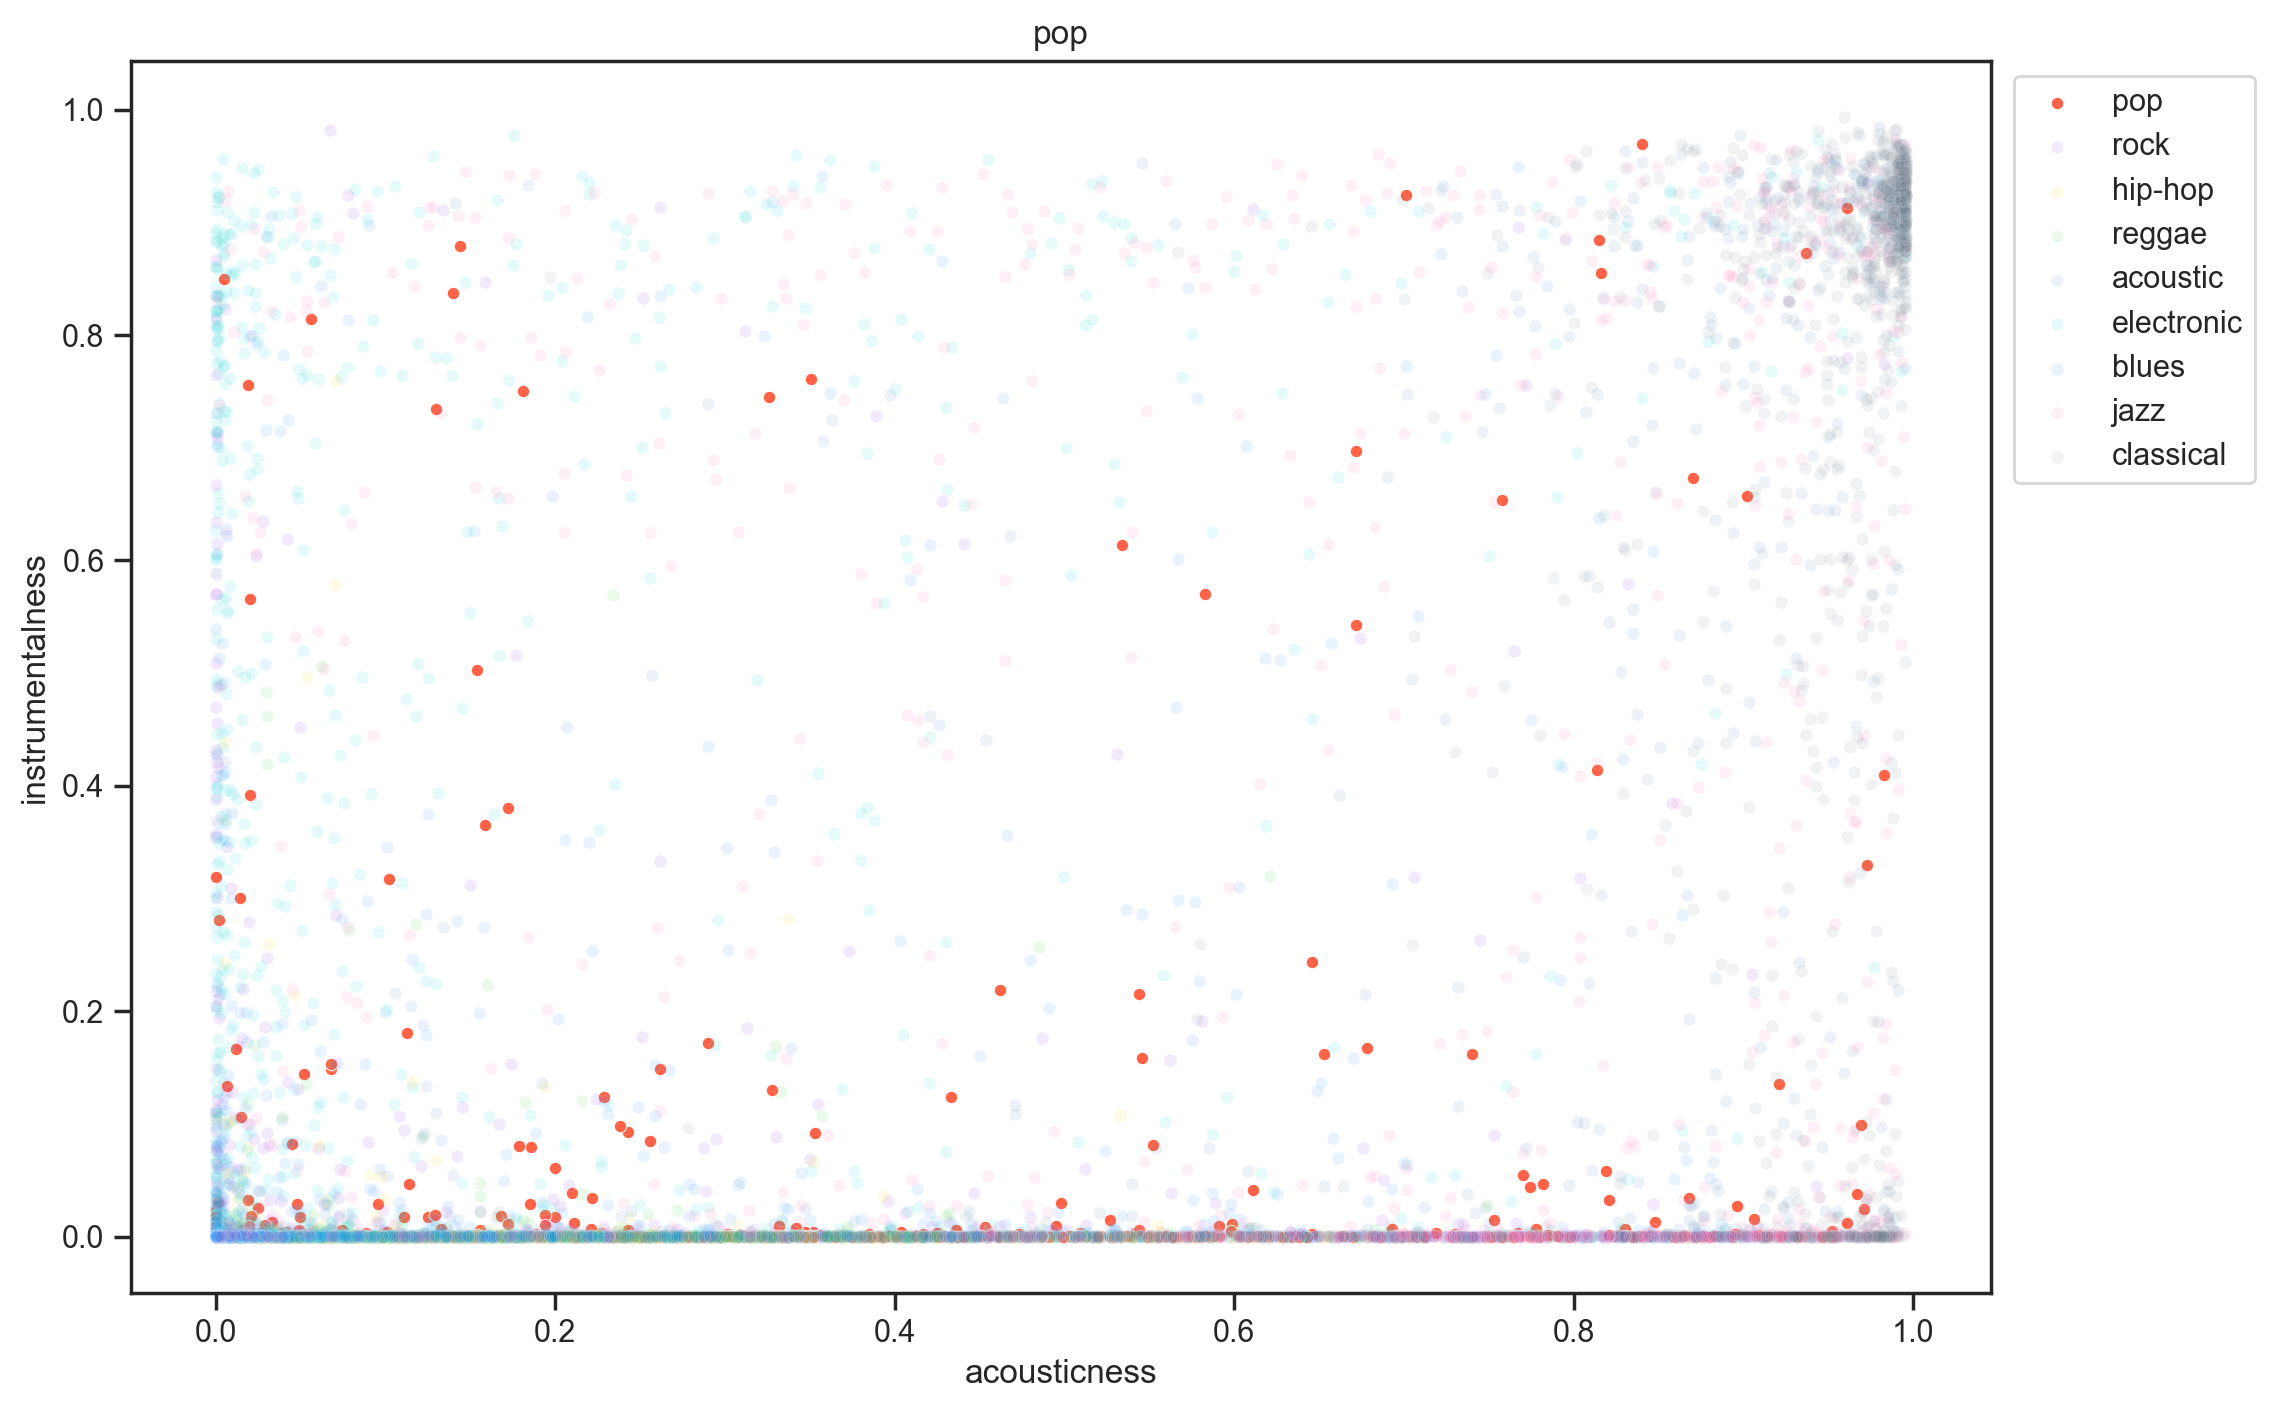

In [80]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.rcParams['figure.dpi'] = 200


# Function to update plot for each frame in the animation
fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['figure.dpi'] = 200

# Function to update plot for each frame in the animation
def update(selected_genre):
    ax.clear()

    # Plot all genres with reduced alpha
    for genre in train_data["genre"].unique():
        genre_data = train_data[train_data['genre'] == genre]
        sns.scatterplot(
            x='acousticness', y='instrumentalness', data=genre_data, color=color_dict[genre], 
            s=20, alpha=0.1 if genre != selected_genre else 1, ax=ax, label=genre
        )
    
    # Title update for each frame
    ax.set_title(f"{selected_genre}")
    ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

# Get unique genres to loop through
unique_genres = train_data['genre'].unique()

# Create the animation
anim = FuncAnimation(fig, update, frames=unique_genres, repeat=True)

# Save the animation as a GIF without using `with` context
gif_path = "../result/acousticness-vs-instrumentalness.gif"
writer = PillowWriter(fps=1)
anim.save(gif_path, writer=writer, dpi=200)

---
# Acousticness and Energy

In [139]:
px.scatter(data_frame=train_data, x="energy", y="acousticness", color="genre", color_discrete_map=color_dict, title="Acousticness and Energy", symbol="genre")


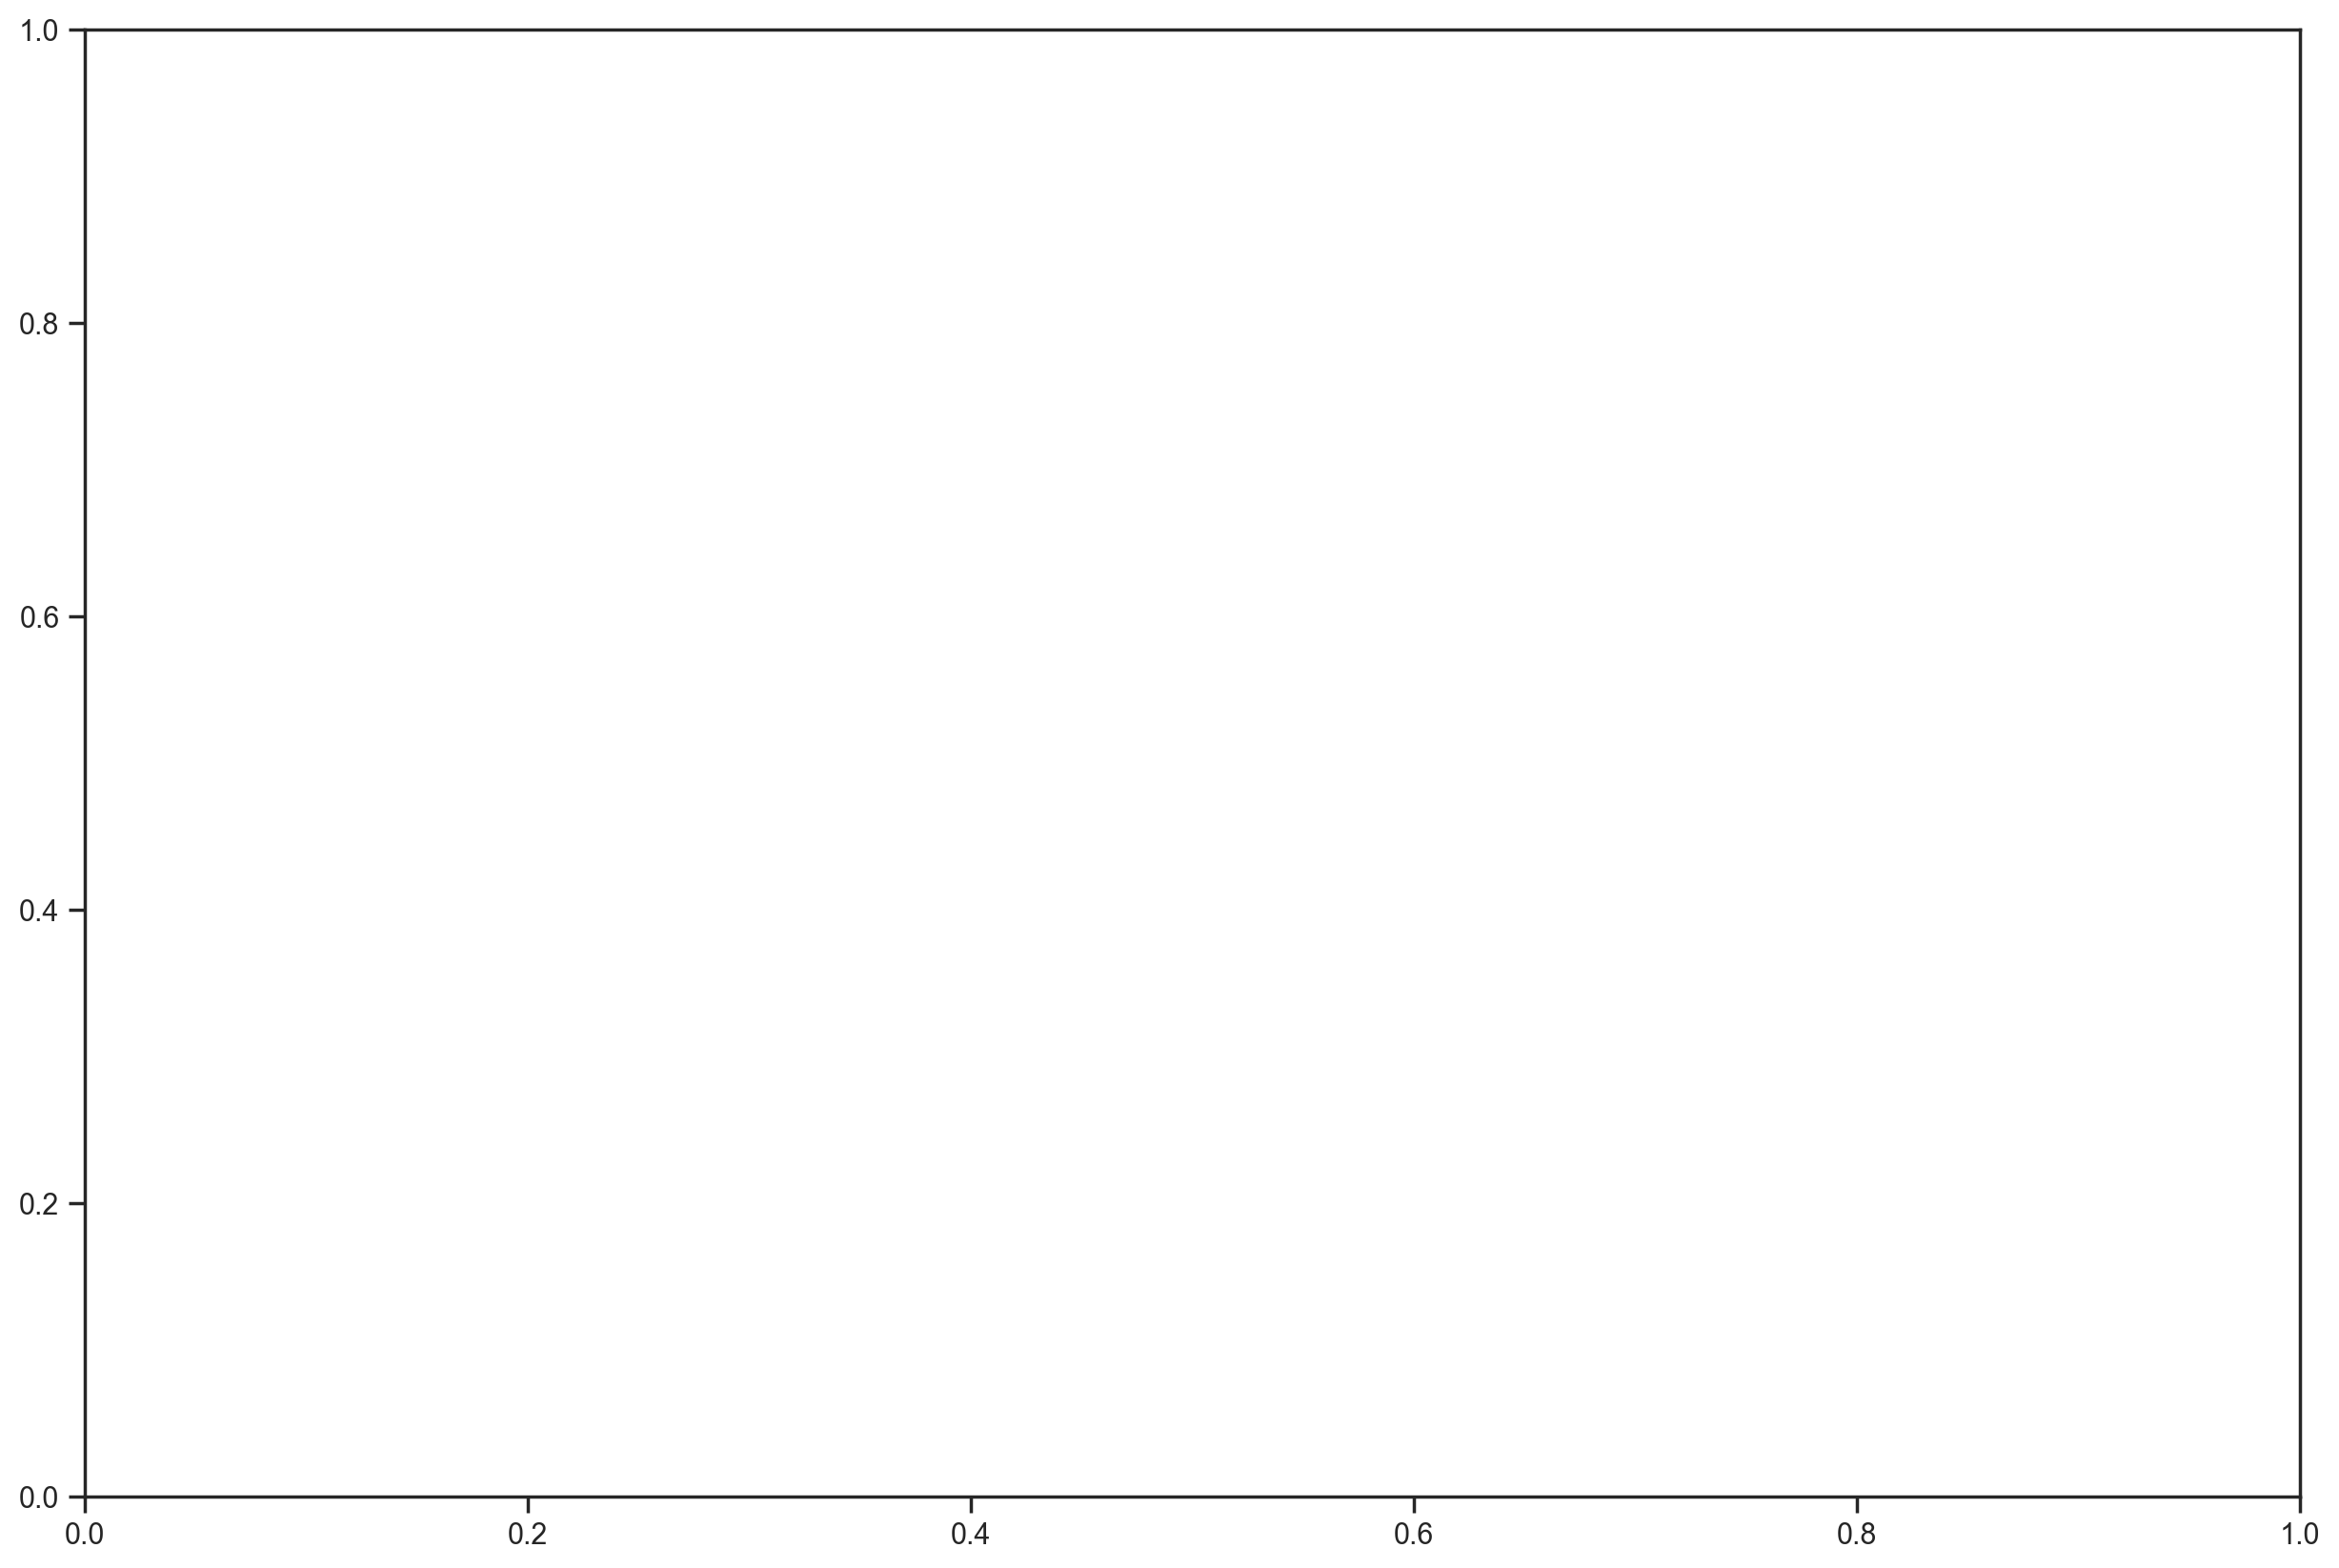

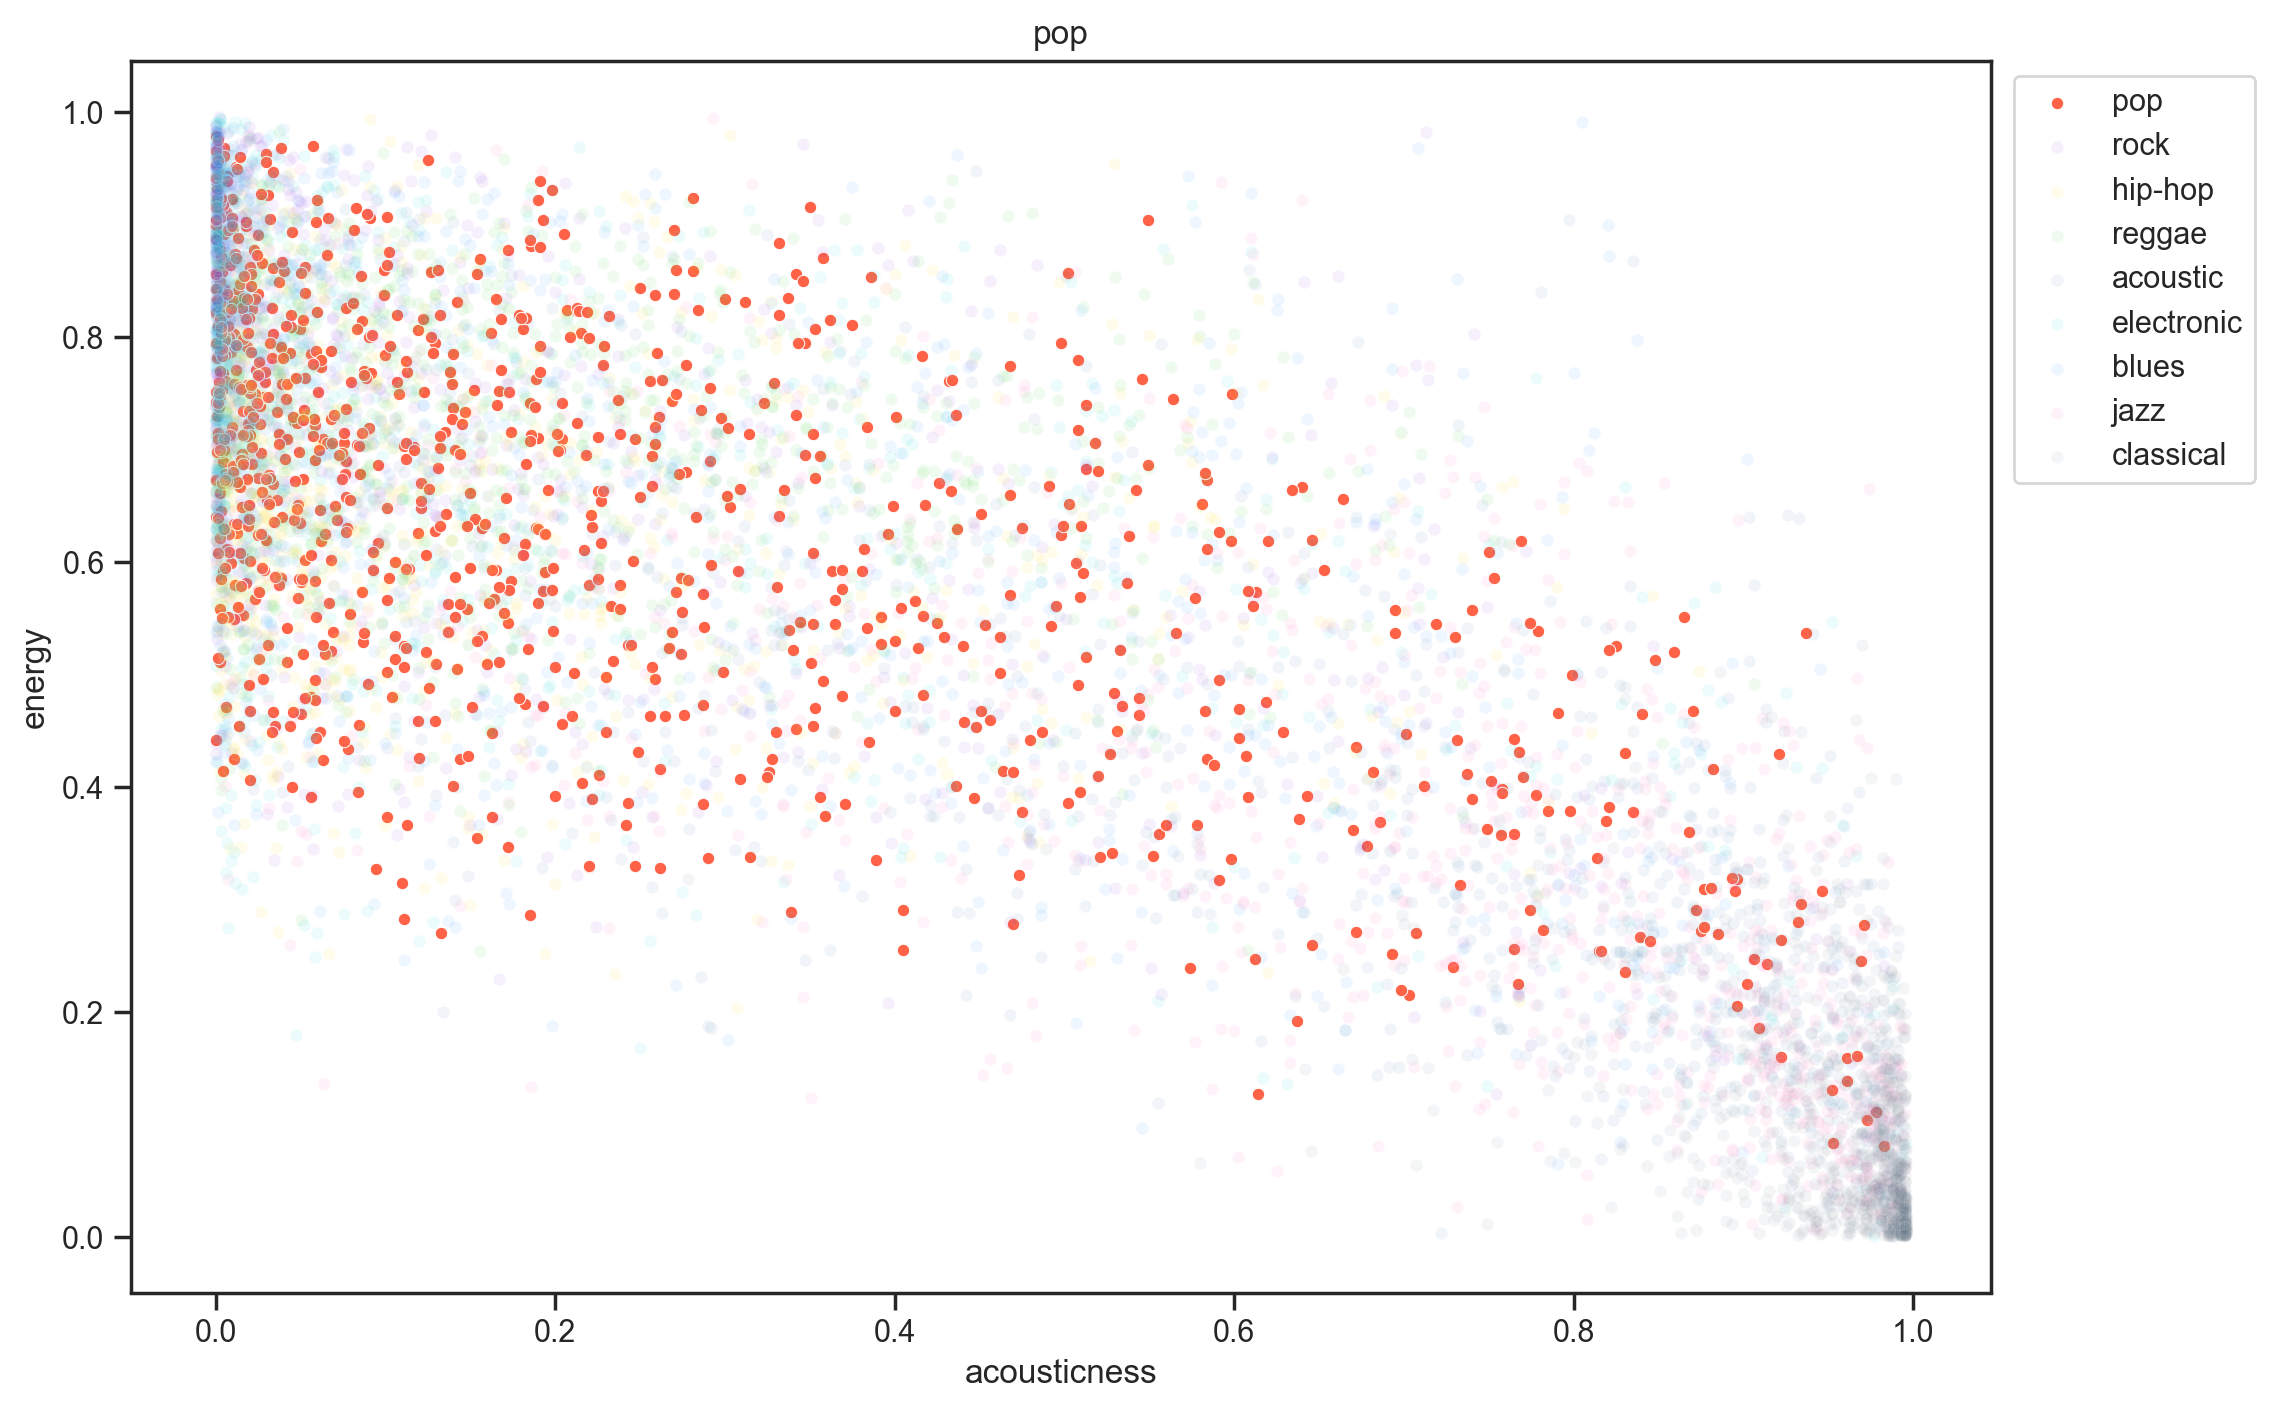

In [141]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.rcParams['figure.dpi'] = 200


# Function to update plot for each frame in the animation
fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['figure.dpi'] = 200

# Function to update plot for each frame in the animation
def update(selected_genre):
    ax.clear()

    # Plot all genres with reduced alpha
    for genre in train_data["genre"].unique():
        genre_data = train_data[train_data['genre'] == genre]
        sns.scatterplot(
            x='acousticness', y='energy', data=genre_data, color=color_dict[genre], 
            s=20, alpha=0.075 if genre != selected_genre else 1, ax=ax, label=genre
        )
    
    # Title update for each frame
    ax.set_title(f"{selected_genre}")
    ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

# Get unique genres to loop through
unique_genres = train_data['genre'].unique()

# Create the animation
anim = FuncAnimation(fig, update, frames=unique_genres, repeat=True)

# Save the animation as a GIF without using `with` context
gif_path = "../result/acousticness-vs-energy.gif"
writer = PillowWriter(fps=1)
anim.save(gif_path, writer=writer, dpi=200)

--- 
# Số lượng artists theo từng thể loại

In [131]:
temp = train_artists.groupby("temp_genre").count()["artist_genres"].sort_values(ascending=False)
fig = px.bar(data_frame=temp, x=temp.index, y=temp,color=temp.index , color_discrete_map=color_dict, title="Số lượng nghệ sĩ theo từng thể loại")

fig.update_layout(
    xaxis_title="genre", yaxis_title="count",legend_title="genre"
)

In [143]:
px.scatter(data_frame=train_data, x="energy", y="popularity", color="genre", color_discrete_map=color_dict, symbol="genre", title="Energy and Popularity")

In [144]:
px.scatter(data_frame=train_data, x="danceability", y="popularity", color="genre", color_discrete_map=color_dict, symbol="genre", title="Danceability and Popularity")

In [175]:
daily_vn_tracks.groupby('album_release_date').count().reset_index()

album_release_date  spotify_id  name  artists  artists_ids  song_genre   
0           1994-10-28           1     1        1            1           1  \
1           2014-11-24           1     1        1            1           1   
2           2015-04-29           7     7        7            7           7   
3           2015-11-30           3     3        3            3           3   
4           2016-01-01          72    72       72           72          72   
..                 ...         ...   ...      ...          ...         ...   
181         2024-10-18           9     9        9            9           9   
182         2024-10-21           7     7        7            7           7   
183         2024-10-22           5     5        5            5           5   
184         2024-10-23           5     5        5            5           5   
185         2024-10-25           4     4        4            4           4   

     daily_rank  daily_movement  weekly_movement  country  ...  key  loudness   
0             1               1                1        1  ...    1         1  \
1             1               1                1        1  ...    1         1   
2             7               7                7        7  ...    7         7   
3             3               3                3        3  ...    3         3   
4            72              72               72       72  ...   72        72   
..          ...             ...              ...      ...  ...  ...       ...   
181           9               9                9        9  ...    9         9   
182           7               7                7        7  ...    7         7   
183           5               5                5        5  ...    5         5   
184           5               5                5        5  ...    5         5   
185           4               4                4        4  ...    4         4   

     mode  speechiness  acousticness  instrumentalness  liveness  valence   
0       1            1             1                 1         1        1  \
1       1            1             1                 1         1        1   
2       7            7             7                 7         7        7   
3       3            3             3                 3         3        3   
4      72           72            72                72        72       72   
..    ...          ...           ...               ...       ...      ...   
181     9            9             9                 9         9        9   
182     7            7             7                 7         7        7   
183     5            5             5                 5         5        5   
184     5            5             5                 5         5        5   
185     4            4             4                 4         4        4   

     tempo  time_signature  
0        1               1  
1        1               1  
2        7               7  
3        3               3  
4       72              72  
..     ...             ...  
181      9               9  
182      7               7  
183      5               5  
184      5               5  
185      4               4  

[186 rows x 27 columns]

In [ ]:
daily_vn_tracks['album_release_date'] = pd.to_datetime(daily_vn_tracks['album_release_date'])
# Step 2: Extract Year-Month as a new column
daily_vn_tracks['album_release_month'] = daily_vn_tracks['album_release_date'].dt.to_period('M')
temp = daily_vn_tracks.groupby(['album_release_month', "song_genre"]).count().reset_index()
months = sorted(pd.to_datetime(temp["album_release_month"].astype("str"), format="%Y-%m").dt.strftime("%Y-%m"))

# Step 3: Create the stacked bar chart using Plotly Express
fig = px.bar(data_frame=temp, 
             x=(months), 
             y="name",  # Count of tracks
             color="song_genre",  # Stack by genre
             color_discrete_map=color_dict,  # Apply the custom colors
             labels={"name": "Number of Tracks", "album_release_date": "Release Date", "genre": "Genre"}, title="Số bài hát ra mắt theo các thời điểm"
        )
fig.update_xaxes(categoryarray=months, type="category", tickangle=-75) 
fig.update_layout(legend_title="genre")
# Step 4: Display the plot
fig.show()

---
# Trung bình các audio features

In [ ]:
fig = make_subplots(rows=2, cols=2)
features = [["danceability", "energy"], ["tempo", "valence"]]
for i in range(1, len(features) + 1):
    for j in range(1, len(features[0]) + 1):
        feat = features[i-1][j-1]
        temp = train_data.groupby("genre")[feat].mean().reset_index().sort_values(by=feat, ascending=False)
        fig.add_trace(
            go.Bar(
                x=temp["genre"], 
                y=temp[feat], 
                marker=dict(color=[color_dict.get(genre, "blue") for genre in temp["genre"]])
                
            ),
            row=i, col=j
        )

        fig.update_xaxes(title_text="Genre")
        fig.update_yaxes(title_text=f"{feat}", row=i, col=j)

fig.update_layout(
    title=f"Average of features",
    showlegend=False
)

fig.show()

In [386]:
temp = daily_vn_tracks.groupby("song_genre")["danceability"].mean().sort_values(ascending=False).reset_index()
px.bar(data_frame=temp, x="song_genre", y="danceability", color="song_genre", color_discrete_map=color_dict, title="Trung bình danceability theo các thể loại")

---
# Phân phối thứ trưởng của top daily vn

In [384]:
temp = daily_vn_tracks.groupby(["mode", "song_genre"])["mode"].size().reset_index(name="count")
px.bar(data_frame=temp, x="mode", y="count", color="song_genre", color_discrete_map=color_dict, title="Số lượng các bài theo tông thứ và trưởng")

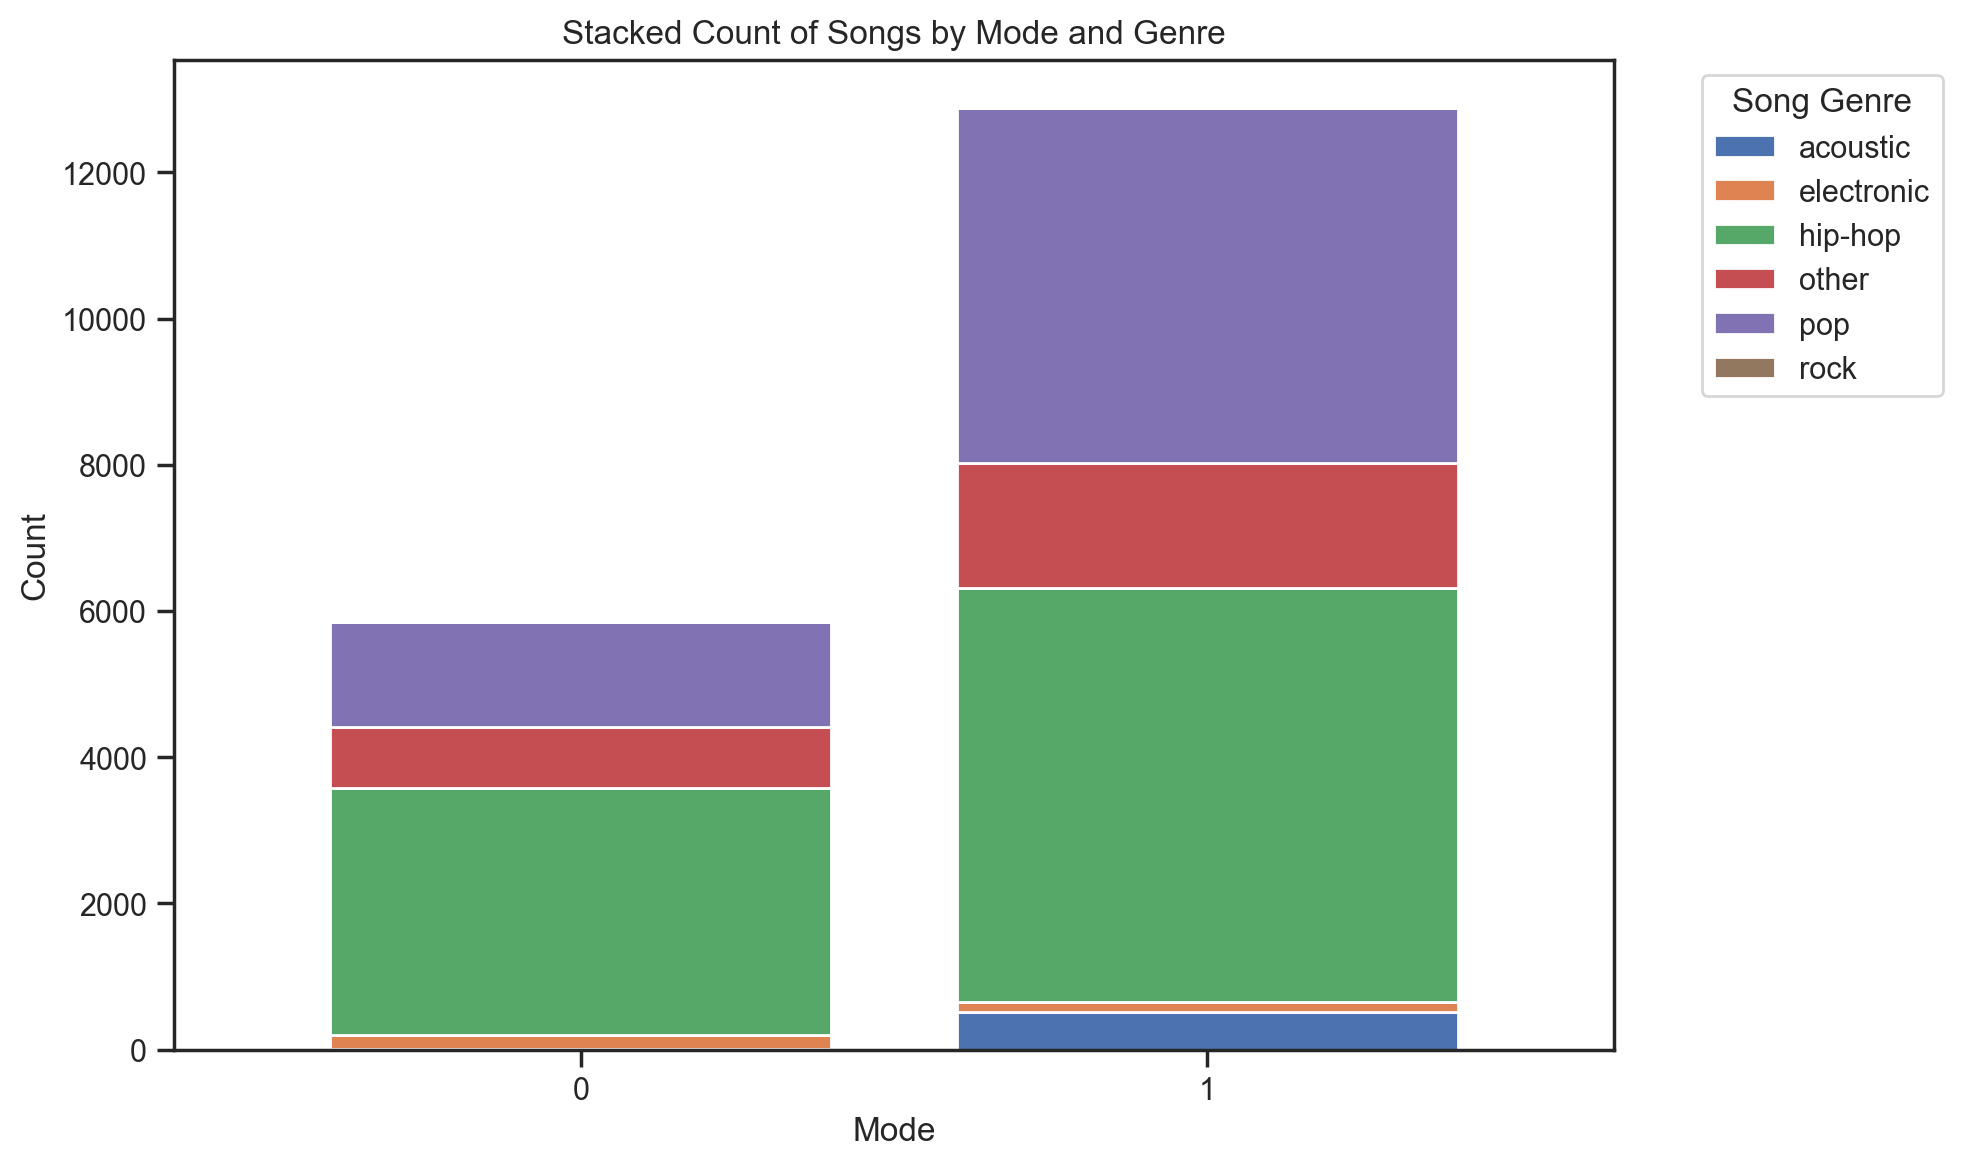